In [4]:
import pandas as pd
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import  MLPClassifier, MLPRegressor

# XAI libraries
import dalex as dx
from lime.lime_tabular import LimeTabularExplainer 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Other libraries
# from utils import plotModelGridError, confusion_matrix
from neuralsens import partial_derivatives as ns
from sklearn import set_config
set_config(display='diagram')

### 0. Data load

In [5]:
df = pd.read_csv('../data/processed/calls_2025_05_28.csv')
df_cleaned = df[['strike', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'price', 'duration', 'remaining', 'midPrice']].copy()
df_cleaned = df_cleaned.dropna()
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 132230 entries, 0 to 146087
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   strike             132230 non-null  float64
 1   volume             132230 non-null  float64
 2   openInterest       132230 non-null  float64
 3   impliedVolatility  132230 non-null  float64
 4   inTheMoney         132230 non-null  bool   
 5   price              132230 non-null  float64
 6   duration           132230 non-null  int64  
 7   remaining          132230 non-null  int64  
 8   midPrice           132230 non-null  float64
dtypes: bool(1), float64(6), int64(2)
memory usage: 9.2 MB


In [6]:
# Take a subset of the data, 20.000 rows
df_reduced = df_cleaned.sample(n=20000, random_state=42)
df_reduced['inTheMoney'] = df_reduced['inTheMoney'].astype('category')
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 13947 to 131873
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   strike             20000 non-null  float64 
 1   volume             20000 non-null  float64 
 2   openInterest       20000 non-null  float64 
 3   impliedVolatility  20000 non-null  float64 
 4   inTheMoney         20000 non-null  category
 5   price              20000 non-null  float64 
 6   duration           20000 non-null  int64   
 7   remaining          20000 non-null  int64   
 8   midPrice           20000 non-null  float64 
dtypes: category(1), float64(6), int64(2)
memory usage: 1.4 MB


In [7]:
numeric_cols = df_reduced.select_dtypes(include=['float64', 'int64'])
categorical_cols = df_reduced.select_dtypes(include=['category'])

### 1. EDA

Text(0.5, 1.0, 'Correlation Matrix')

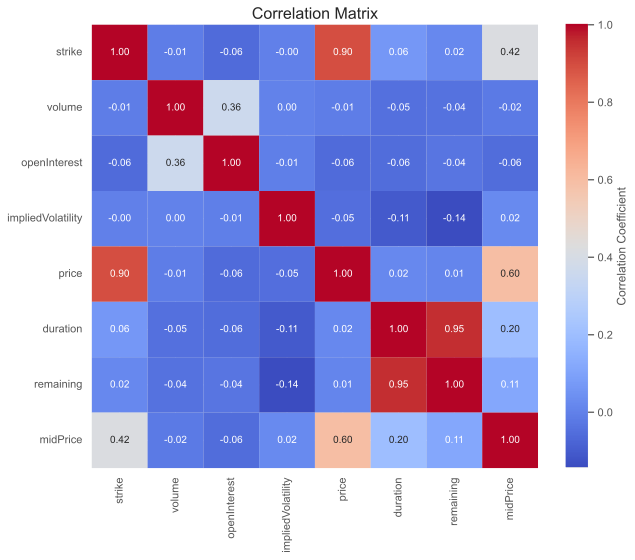

In [21]:
# Create a correlation matrix
corr_matrix = numeric_cols.corr()

# Set the plot size
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})

# Set the title
plt.title('Correlation Matrix', fontsize=16)

# Display the plot

In [ ]:
sns.pairplot(data = df_reduced, y_vars=['midPrice'])
plt.show()

In [ ]:
sns.catplot(x='inTheMoney', y='midPrice', data=df_reduced, kind='box')
plt.show()

### 2. Data split

In [8]:
INPUTS = ['strike', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'price', 'duration', 'remaining']
OUTPUT = 'midPrice'

X = df_reduced[INPUTS]
y = df_reduced[OUTPUT]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

strike  volume  openInterest  impliedVolatility inTheMoney   price  \
92475    70.0    40.0       13452.0           0.268562      False   66.62   
76709   124.0    26.0         626.0           0.593754      False   84.00   
11215   237.5     4.0           4.0           0.293342      False  215.62   
17919   185.0     6.0          16.0           0.246590      False  173.01   
535     110.0     1.0         931.0           0.503911       True  132.02   

       duration  remaining  
92475        22         22  
76709        43         22  
11215        23         22  
17919        50         50  
535          29         22

In [9]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['midPrice'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['midPrice'] = y_test

### 3. Modelo A (Más parámetros)

In [10]:
INPUTS_MLP_NUM = ['strike', 'volume', 'openInterest', 'impliedVolatility', 'price', 'duration', 'remaining']
INPUTS_MLP_CAT = ['inTheMoney']
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.01, 0.001], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(30,),(40,),(60,)],
         'MLP__learning_rate_init':[0.1]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit_A = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit_A.fit(X_train[INPUTS_MLP], y_train) # Search in grid


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          331     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17207D+04    |proj g|=  5.13582D+01

At iterate    1    f=  1.10337D+04    |proj g|=  3.63813D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          331     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13296D+04    |proj g|=  5.06055D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          331     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17538D+04    |proj g|=  5.06895D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          331     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18344D+04    |proj g|=  5.13375D+01
RUNNING THE L-BFGS-B C

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    2    f=  9.70658D+03    |proj g|=  3.27023D+01

At iterate    3    f=  7.99147D+03    |proj g|=  1.88127D+01

At iterate    5    f=  7.17885D+03    |proj g|=  2.33193D+01

At iterate    2    f=  9.66740D+03    |proj g|=  3.42546D+01

At iterate    4    f=  6.89065D+03    |proj g|=  2.09509D+01

At iterate    6    f=  6.68429D+03    |proj g|=  1.78749D+01

At iterate    3    f=  8.58453D+03    |proj g|=  1.88218D+01

At iterate    5    f=  6.45777D+03    |proj g|=  1.86459D+01

At iterate    1    f=  1.06554D+04    |proj g|=  3.56206D+01

At iterate    7    f=  6.04169D+03    |proj g|=  5.26532D+01

At iterate    4    f=  7.48691D+03    |proj g|=  4.35775D+01

At iterate    6    f=  6.12180D+03    |proj g|=  1.82497D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          331     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12492D+04    |proj g|=  5.06133D+01

At iterate    5    f=  7.0

 This problem is unconstrained.



At iterate   17    f=  2.67203D+03    |proj g|=  2.96599D+01

At iterate    2    f=  9.96226D+03    |proj g|=  3.32489D+01

At iterate    9    f=  4.90562D+03    |proj g|=  3.20238D+01

At iterate   10    f=  4.71524D+03    |proj g|=  2.85938D+01

At iterate    9    f=  5.34257D+03    |proj g|=  2.35548D+01

At iterate   10    f=  4.44242D+03    |proj g|=  2.30983D+01

At iterate   11    f=  4.19643D+03    |proj g|=  2.04852D+01

At iterate    3    f=  8.84977D+03    |proj g|=  1.93649D+01

At iterate   18    f=  2.78734D+03    |proj g|=  1.46730D+01

At iterate   10    f=  4.99950D+03    |proj g|=  2.10314D+01

At iterate   18    f=  2.58244D+03    |proj g|=  2.19307D+01

At iterate   12    f=  3.84873D+03    |proj g|=  3.18252D+01

At iterate   11    f=  4.08738D+03    |proj g|=  1.85798D+01

At iterate   12    f=  3.98714D+03    |proj g|=  2.55070D+01

At iterate   19    f=  2.50091D+03    |proj g|=  2.78914D+01

At iterate   11    f=  4.55413D+03    |proj g|=  2.48354D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs fa


At iterate  429    f=  8.79120D+02    |proj g|=  1.21950D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          331     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16636D+04    |proj g|=  5.08507D+01

At iterate    1    f=  1.07822D+04    |proj g|=  3.58622D+01

At iterate  430    f=  8.78568D+02    |proj g|=  1.85000D+00

At iterate    1    f=  1.09844D+04    |proj g|=  3.58767D+01

At iterate    2    f=  9.66836D+03    |proj g|=  3.53953D+01

At iterate    3    f=  8.56851D+03    |proj g|=  1.94983D+01

At iterate    2    f=  9.86436D+03    |proj g|=  3.28197D+01

At iterate    4    f=  7.44445D+03    |proj g|=  2.93663D+01

At iterate    5    f=  6.99088D+03    |proj g|=  1.92668D+01

At iterate    3    f=  8.74202D+03    |proj g|=  1.96947D+01

At iterate    4    f=  7.61569D+03    |proj g|=  6.65446D+01

At iterate    5    f=  7.18645D+03    |proj g|=  2.42115D+01

At iterate    6    f=  6.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   11    f=  4.67070D+03    |proj g|=  2.34632D+01

At iterate    2    f=  9.07945D+03    |proj g|=  3.67589D+01

At iterate   14    f=  3.24800D+03    |proj g|=  1.88187D+01

At iterate   12    f=  4.30933D+03    |proj g|=  3.00671D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          441     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17533D+04    |proj g|=  5.19951D+01

At iterate  436    f=  8.76996D+02    |proj g|=  2.39644D+00

At iterate   15    f=  3.04265D+03    |proj g|=  1.84334D+01

At iterate    3    f=  8.08960D+03    |proj g|=  3.61122D+01

At iterate    1    f=  1.10559D+04    |proj g|=  3.49318D+01

At iterate   13    f=  3.92269D+03    |proj g|=  2.06486D+01

At iterate  437    f=  8.76763D+02    |proj g|=  2.61457D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          441     M =           10

At X0         0 variables are exactl

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   17    f=  2.82735D+03    |proj g|=  1.23841D+01

At iterate   13    f=  3.83747D+03    |proj g|=  2.63387D+01

At iterate   10    f=  4.73060D+03    |proj g|=  2.05900D+01

At iterate   32    f=  2.30268D+03    |proj g|=  4.35450D+01

At iterate   10    f=  4.93018D+03    |proj g|=  1.99416D+01

At iterate   18    f=  2.68315D+03    |proj g|=  1.29475D+01

At iterate   11    f=  4.40510D+03    |proj g|=  1.99724D+01

At iterate   14    f=  3.44633D+03    |proj g|=  1.74086D+01

At iterate   11    f=  4.66234D+03    |proj g|=  2.47454D+01

At iterate   19    f=  2.59997D+03    |proj g|=  1.88258D+01

At iterate   12    f=  4.03428D+03    |proj g|=  2.34387D+01

At iterate   12    f=  4.13239D+03    |proj g|=  2.20482D+01

At iterate   33    f=  2.23829D+03    |proj g|=  2.40369D+01

At iterate   13    f=  3.51980D+03    |proj g|=  2.19952D+01

At iterate   20    f=  2.52331D+03    |proj g|=  1.03264D+01

At iterate   13    f=  3.52790D+03    |proj g|=  1.57286D+01

At iter

 This problem is unconstrained.



At iterate   19    f=  2.55263D+03    |proj g|=  2.23598D+01

At iterate   24    f=  2.35556D+03    |proj g|=  1.38742D+01

At iterate   37    f=  2.20007D+03    |proj g|=  6.00409D+00

At iterate   44    f=  2.05977D+03    |proj g|=  8.56593D+00

At iterate   45    f=  2.03198D+03    |proj g|=  1.54924D+01

At iterate   25    f=  2.31026D+03    |proj g|=  8.42454D+00

At iterate   26    f=  2.29051D+03    |proj g|=  8.48925D+00

At iterate   27    f=  2.27353D+03    |proj g|=  8.59228D+00

At iterate   21    f=  2.47059D+03    |proj g|=  1.04104D+01

At iterate    1    f=  1.07765D+04    |proj g|=  3.45758D+01

At iterate   20    f=  2.46684D+03    |proj g|=  1.80002D+01

At iterate   22    f=  2.42687D+03    |proj g|=  1.13990D+01

At iterate   23    f=  2.38344D+03    |proj g|=  1.00721D+01

At iterate   24    f=  2.35196D+03    |proj g|=  9.60285D+00

At iterate    2    f=  9.70585D+03    |proj g|=  3.93107D+01

At iterate   46    f=  2.00987D+03    |proj g|=  1.20995D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.



At iterate  368    f=  8.84801D+02    |proj g|=  3.16775D+00

At iterate  377    f=  8.01413D+02    |proj g|=  5.87623D+00

At iterate  335    f=  1.04417D+03    |proj g|=  2.75391D+00

At iterate  339    f=  8.31281D+02    |proj g|=  1.28573D+00

At iterate  369    f=  8.83449D+02    |proj g|=  4.19723D+00

At iterate  336    f=  1.04344D+03    |proj g|=  7.48377D+00

At iterate  340    f=  8.29831D+02    |proj g|=  3.05983D+00

At iterate  378    f=  8.00276D+02    |proj g|=  5.09574D+00

At iterate  351    f=  8.08712D+02    |proj g|=  2.32316D+00

At iterate  369    f=  7.46527D+02    |proj g|=  3.80960D+00

At iterate  370    f=  8.82431D+02    |proj g|=  6.24816D+00

At iterate  352    f=  8.08275D+02    |proj g|=  1.65732D+00

At iterate  371    f=  8.81213D+02    |proj g|=  9.51104D+00

At iterate  341    f=  8.29227D+02    |proj g|=  2.79053D+00

At iterate  370    f=  7.45526D+02    |proj g|=  1.38866D+00

At iterate  372    f=  8.79347D+02    |proj g|=  6.97094D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:5


At iterate  444    f=  7.22412D+02    |proj g|=  1.13745D+00

At iterate   76    f=  1.53969D+03    |proj g|=  5.52009D+00

At iterate  445    f=  8.11542D+02    |proj g|=  8.72665D+00

At iterate  434    f=  7.40047D+02    |proj g|=  7.83294D+00

At iterate  412    f=  9.98823D+02    |proj g|=  5.05976D+00

At iterate   75    f=  1.68172D+03    |proj g|=  1.82966D+01

At iterate   77    f=  1.53030D+03    |proj g|=  3.22642D+00

At iterate  435    f=  7.39463D+02    |proj g|=  3.28078D+00

At iterate  413    f=  9.98670D+02    |proj g|=  3.35927D+00

At iterate  446    f=  8.11363D+02    |proj g|=  8.73441D+00

At iterate  445    f=  7.22177D+02    |proj g|=  2.13516D+00

At iterate   76    f=  1.67263D+03    |proj g|=  2.04504D+01

At iterate  413    f=  7.99876D+02    |proj g|=  2.37033D+00

At iterate  414    f=  9.98462D+02    |proj g|=  1.05801D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          441     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   85    f=  1.60303D+03    |proj g|=  1.85306D+01

At iterate    1    f=  1.09631D+04    |proj g|=  3.50900D+01

At iterate  423    f=  9.95012D+02    |proj g|=  9.23564D+00

At iterate   88    f=  1.40433D+03    |proj g|=  1.95940D+01

At iterate    9    f=  5.18515D+03    |proj g|=  2.18951D+01

At iterate  424    f=  7.97309D+02    |proj g|=  1.47872D+00

At iterate  424    f=  9.94356D+02    |proj g|=  2.76296D+00

At iterate   86    f=  1.59417D+03    |proj g|=  7.05825D+00

At iterate  445    f=  7.33196D+02    |proj g|=  5.73785D+00

At iterate   89    f=  1.39023D+03    |proj g|=  7.16965D+00

At iterate   10    f=  4.87790D+03    |proj g|=  1.99368D+01

At iterate  425    f=  7.97145D+02    |proj g|=  1.79656D+00

At iterate  446    f=  7.32341D+02    |proj g|=  2.96914D+00

At iterate   87    f=  1.58802D+03    |proj g|=  1.30498D+01

At iterate  425    f=  9.93932D+02    |proj g|=  3.05361D+00

At iterate    2    f=  9.86371D+03    |proj g|=  4.00927D+01

At iter

 This problem is unconstrained.



At iterate    8    f=  5.35146D+03    |proj g|=  3.64375D+01

At iterate   22    f=  2.50868D+03    |proj g|=  8.19960D+00

At iterate  101    f=  1.32873D+03    |proj g|=  7.94005D+00

At iterate  438    f=  7.94880D+02    |proj g|=  8.76880D-01

At iterate   16    f=  3.24310D+03    |proj g|=  1.34584D+01

At iterate   98    f=  1.50658D+03    |proj g|=  5.85747D+00


At iterate   99    f=  1.49697D+03    |proj g|=  1.03035D+01
At iterate   23    f=  2.46838D+03    |proj g|=  1.28768D+01

At iterate  439    f=  7.94799D+02    |proj g|=  4.56506D-01

At iterate    9    f=  4.93474D+03    |proj g|=  2.68423D+01

At iterate   17    f=  2.99757D+03    |proj g|=  1.01187D+01

At iterate  100    f=  1.48741D+03    |proj g|=  8.28248D+00

At iterate  440    f=  7.94663D+02    |proj g|=  1.00120D+00

At iterate  432    f=  9.85792D+02    |proj g|=  5.99836D+00

At iterate   18    f=  2.81366D+03    |proj g|=  1.68951D+01

At iterate  101    f=  1.48114D+03    |proj g|=  1.80857D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  110    f=  1.21376D+03    |proj g|=  6.71066D+00

At iterate   29    f=  2.12648D+03    |proj g|=  1.30973D+01

At iterate    9    f=  5.51855D+03    |proj g|=  2.66653D+01

At iterate  112    f=  1.43049D+03    |proj g|=  1.87671D+01

At iterate   19    f=  2.58686D+03    |proj g|=  9.30893D+00

At iterate  443    f=  9.79267D+02    |proj g|=  1.48101D+00

At iterate   30    f=  2.11118D+03    |proj g|=  1.55771D+01

At iterate   36    f=  2.21623D+03    |proj g|=  9.13203D+00

At iterate   10    f=  5.09310D+03    |proj g|=  1.58174D+01

At iterate  113    f=  1.42122D+03    |proj g|=  9.47916D+00

At iterate   31    f=  2.10491D+03    |proj g|=  1.68892D+01

At iterate   20    f=  2.55089D+03    |proj g|=  7.13880D+00

At iterate  444    f=  9.79098D+02    |proj g|=  6.76684D-01

At iterate  114    f=  1.41793D+03    |proj g|=  7.56393D+00

At iterate  111    f=  1.21350D+03    |proj g|=  9.41768D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   16    f=  2.95314D+03    |proj g|=  1.59812D+01

At iterate  135    f=  1.10730D+03    |proj g|=  7.19753D+00

At iterate   38    f=  2.00414D+03    |proj g|=  8.30349D+00

At iterate   56    f=  1.83097D+03    |proj g|=  1.20408D+01

At iterate   65    f=  1.84279D+03    |proj g|=  1.31147D+01

At iterate   27    f=  2.21067D+03    |proj g|=  1.49317D+01

At iterate  136    f=  1.33316D+03    |proj g|=  6.55697D+00

At iterate  136    f=  1.10504D+03    |proj g|=  8.70737D+00

At iterate    8    f=  5.86478D+03    |proj g|=  3.34484D+01

At iterate   17    f=  2.82825D+03    |proj g|=  3.16940D+01

At iterate   66    f=  1.83139D+03    |proj g|=  1.50999D+01

At iterate   57    f=  1.82906D+03    |proj g|=  2.19478D+01

At iterate  137    f=  1.32938D+03    |proj g|=  4.47504D+00


At iterate  137    f=  1.10180D+03    |proj g|=  3.21904D+00
At iterate   28    f=  2.17339D+03    |proj g|=  7.90759D+00

At iterate   39    f=  2.00339D+03    |proj g|=  8.77088D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


At iterate  222    f=  9.57516D+02    |proj g|=  3.77347D+00

At iterate  427    f=  8.64135D+02    |proj g|=  2.02976D+00

At iterate  352    f=  8.84709D+02    |proj g|=  4.20736D+00

At iterate  223    f=  9.52856D+02    |proj g|=  2.87769D+00

At iterate  253    f=  8.12740D+02    |proj g|=  1.59813D+00

At iterate  230    f=  8.86046D+02    |proj g|=  1.87575D+00

At iterate  221    f=  8.74069D+02    |proj g|=  2.27986D+00

At iterate  357    f=  8.53493D+02    |proj g|=  3.04683D+00

At iterate  428    f=  8.63661D+02    |proj g|=  3.38668D+00

At iterate  353    f=  8.84180D+02    |proj g|=  2.44587D+00

At iterate  222    f=  8.72395D+02    |proj g|=  3.04647D+00

At iterate  358    f=  8.52711D+02    |proj g|=  2.25547D+00

At iterate  254    f=  8.11354D+02    |proj g|=  2.07152D+00

At iterate  354    f=  8.83714D+02    |proj g|=  3.26445D+00

At iterate  231    f=  8.83636D+02    |proj g|=  4.81634D+00


At iterate  429    f=  8.63056D+02    |proj g|=  5.75638D+00
At itera

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  241    f=  9.03164D+02    |proj g|=  5.40744D+00

At iterate  390    f=  8.24419D+02    |proj g|=  8.07513D+00

At iterate  384    f=  8.61700D+02    |proj g|=  4.44698D+00

At iterate   23    f=  2.25682D+03    |proj g|=  1.76526D+01

At iterate    2    f=  1.00181D+04    |proj g|=  4.36262D+01

At iterate  278    f=  7.90750D+02    |proj g|=  4.02077D+00

At iterate  244    f=  8.26772D+02    |proj g|=  3.60574D+00

At iterate  254    f=  8.46229D+02    |proj g|=  5.10613D+00

At iterate  385    f=  8.60611D+02    |proj g|=  1.24004D+01

At iterate  391    f=  8.23745D+02    |proj g|=  2.45266D+00

At iterate  242    f=  9.02034D+02    |proj g|=  2.84436D+00

At iterate    3    f=  8.82355D+03    |proj g|=  1.31614D+01

At iterate  386    f=  8.59579D+02    |proj g|=  3.40596D+00

At iterate  279    f=  7.89527D+02    |proj g|=  8.34845D+00

At iterate  392    f=  8.22959D+02    |proj g|=  2.49883D+00

At iterate   24    f=  2.20552D+03    |proj g|=  1.33971D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.



At iterate  325    f=  7.47688D+02    |proj g|=  7.31652D+00

At iterate  294    f=  7.61869D+02    |proj g|=  4.09880D+00

At iterate  297    f=  7.68763D+02    |proj g|=  4.01797D+00

At iterate  285    f=  8.38888D+02    |proj g|=  2.06515D+00

At iterate   64    f=  1.53229D+03    |proj g|=  1.18237D+01

At iterate   48    f=  1.88210D+03    |proj g|=  1.38165D+01

At iterate  298    f=  7.67071D+02    |proj g|=  2.03576D+00

At iterate  295    f=  7.61404D+02    |proj g|=  1.53978D+00

At iterate  286    f=  8.37160D+02    |proj g|=  4.85990D+00

At iterate   65    f=  1.52500D+03    |proj g|=  9.12563D+00

At iterate  326    f=  7.46025D+02    |proj g|=  1.32356D+01

At iterate  299    f=  7.65903D+02    |proj g|=  1.92193D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          661     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12852D+04    |proj g|=  5.13313D+01

At iterate  296    f=  7.6

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  413    f=  7.07630D+02    |proj g|=  2.15012D+00

At iterate  422    f=  6.84241D+02    |proj g|=  1.19648D+00

At iterate  433    f=  6.44137D+02    |proj g|=  2.58583D+00

At iterate  175    f=  1.13041D+03    |proj g|=  3.58402D+00

At iterate  131    f=  1.11943D+03    |proj g|=  3.10077D+00

At iterate  190    f=  9.90128D+02    |proj g|=  4.02523D+00

At iterate  132    f=  1.11800D+03    |proj g|=  1.01842D+01

At iterate  434    f=  6.43993D+02    |proj g|=  8.42141D+00

At iterate  423    f=  6.84040D+02    |proj g|=  1.86327D+00

At iterate  414    f=  7.07073D+02    |proj g|=  3.25675D+00

At iterate  176    f=  1.12820D+03    |proj g|=  5.24487D+00

At iterate  191    f=  9.88046D+02    |proj g|=  3.37555D+00

At iterate  424    f=  6.83683D+02    |proj g|=  2.18242D+00

At iterate  435    f=  6.43308D+02    |proj g|=  2.09147D+00

At iterate  133    f=  1.11624D+03    |proj g|=  3.81926D+00

At iterate  177    f=  1.12546D+03    |proj g|=  6.43946D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  441    f=  6.78615D+02    |proj g|=  1.64348D+00

At iterate  433    f=  6.94360D+02    |proj g|=  3.88043D+00

At iterate  442    f=  6.78359D+02    |proj g|=  1.33423D+00

At iterate  157    f=  1.12790D+03    |proj g|=  6.41411D+00


At iterate  434    f=  6.93968D+02    |proj g|=  4.53685D+00
At iterate  153    f=  1.07249D+03    |proj g|=  3.00909D+00

At iterate  443    f=  6.77845D+02    |proj g|=  3.17729D+00

At iterate  210    f=  9.62280D+02    |proj g|=  1.11768D+01

At iterate  158    f=  1.12614D+03    |proj g|=  8.22667D+00

At iterate   20    f=  2.55268D+03    |proj g|=  2.02611D+01

At iterate  192    f=  1.06855D+03    |proj g|=  6.34737D+00

At iterate  435    f=  6.93633D+02    |proj g|=  4.90208D+00

At iterate  211    f=  9.59730D+02    |proj g|=  3.70806D+00

At iterate  154    f=  1.07187D+03    |proj g|=  2.06114D+00

At iterate  436    f=  6.92846D+02    |proj g|=  6.53340D+00

At iterate  193    f=  1.06629D+03    |proj g|=  3.04366D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate   32    f=  2.17179D+03    |proj g|=  1.42000D+01

At iterate  223    f=  9.46391D+02    |proj g|=  4.69772D+00

At iterate    5    f=  6.45777D+03    |proj g|=  1.86460D+01

At iterate  166    f=  1.03191D+03    |proj g|=  4.73161D+00

At iterate  207    f=  1.04382D+03    |proj g|=  2.66256D+00

At iterate  449    f=  6.85939D+02    |proj g|=  4.98761D+00

At iterate   12    f=  4.22969D+03    |proj g|=  2.00346D+01

At iterate  173    f=  1.08644D+03    |proj g|=  4.73217D+00

At iterate    6    f=  6.12180D+03    |proj g|=  1.82497D+01

At iterate  224    f=  9.45078D+02    |proj g|=  3.13503D+00

At iterate  174    f=  1.08488D+03    |proj g|=  7.82316D+00

At iterate  208    f=  1.04119D+03    |proj g|=  1.69668D+00

At iterate    7    f=  5.51994D+03    |proj g|=  4.47659D+01

At iterate   33    f=  2.13343D+03    |proj g|=  8.53736D+00

At iterate   13    f=  3.76042D+03    |proj g|=  2.39012D+01

At iterate  167    f=  1.02777D+03    |proj g|=  2.81578D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate   12    f=  3.62073D+03    |proj g|=  2.57507D+01

At iterate  212    f=  1.03090D+03    |proj g|=  5.63977D+00

At iterate  228    f=  9.40169D+02    |proj g|=  4.50865D+00

At iterate   16    f=  2.76831D+03    |proj g|=  1.53135D+01

At iterate  177    f=  1.08007D+03    |proj g|=  3.23964D+00

At iterate   13    f=  3.33860D+03    |proj g|=  2.77640D+01

At iterate  170    f=  1.02100D+03    |proj g|=  2.79823D+00

At iterate  229    f=  9.39323D+02    |proj g|=  6.09888D+00

At iterate   36    f=  2.05495D+03    |proj g|=  1.15348D+01

At iterate    2    f=  9.96226D+03    |proj g|=  3.32489D+01

At iterate   14    f=  3.17238D+03    |proj g|=  3.07230D+01

At iterate  213    f=  1.02597D+03    |proj g|=  6.77975D+00

At iterate   17    f=  2.64250D+03    |proj g|=  2.51353D+01

At iterate    3    f=  8.84977D+03    |proj g|=  1.93649D+01

At iterate   15    f=  3.02325D+03    |proj g|=  2.92056D+01

At iterate  171    f=  1.01993D+03    |proj g|=  2.69359D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  392    f=  8.54972D+02    |proj g|=  4.10476D+00

At iterate    2    f=  9.89129D+03    |proj g|=  3.38662D+01

At iterate  227    f=  7.54672D+02    |proj g|=  6.67959D+00

At iterate  420    f=  7.45494D+02    |proj g|=  1.67232D+00

At iterate  386    f=  8.50493D+02    |proj g|=  3.14691D+00

At iterate  393    f=  8.54008D+02    |proj g|=  2.30742D+00

At iterate  390    f=  7.65882D+02    |proj g|=  1.98870D+00

At iterate    3    f=  8.76196D+03    |proj g|=  2.01008D+01

At iterate  389    f=  8.66573D+02    |proj g|=  1.11318D+01

At iterate  228    f=  7.51329D+02    |proj g|=  3.39364D+00

At iterate    4    f=  7.62395D+03    |proj g|=  6.48317D+01

At iterate  247    f=  9.12628D+02    |proj g|=  4.17379D+00

At iterate  387    f=  8.47406D+02    |proj g|=  7.77864D+00

At iterate  394    f=  8.53173D+02    |proj g|=  2.87278D+00

At iterate  421    f=  7.44979D+02    |proj g|=  1.93097D+00

At iterate    5    f=  7.17884D+03    |proj g|=  2.33193D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:5



At iterate   58    f=  1.91711D+03    |proj g|=  7.82903D+00
At iterate  448    f=  8.17140D+02    |proj g|=  2.60986D+00

At iterate  417    f=  8.19380D+02    |proj g|=  2.34142D+00

At iterate  261    f=  7.07518D+02    |proj g|=  2.46821D+00

At iterate  446    f=  8.26386D+02    |proj g|=  4.13933D+00

At iterate  449    f=  8.16673D+02    |proj g|=  4.92472D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          331     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14388D+04    |proj g|=  5.05741D+01

At iterate   59    f=  1.90871D+03    |proj g|=  3.66438D+01

At iterate  424    f=  7.52384D+02    |proj g|=  3.80773D+00

At iterate  281    f=  8.68043D+02    |proj g|=  5.51138D+00

At iterate  450    f=  8.15972D+02    |proj g|=  6.04686D+00

At iterate   60    f=  1.90355D+03    |proj g|=  2.12014D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate   48    f=  1.93753D+03    |proj g|=  1.38319D+01

At iterate  105    f=  1.55852D+03    |proj g|=  3.63403D+00

At iterate  287    f=  6.78181D+02    |proj g|=  5.25167D+00

At iterate  442    f=  8.03740D+02    |proj g|=  2.21533D+00

At iterate   42    f=  1.92076D+03    |proj g|=  4.62170D+00

At iterate   49    f=  1.92604D+03    |proj g|=  2.06060D+01

At iterate   40    f=  2.26112D+03    |proj g|=  7.10859D+00

At iterate  106    f=  1.55508D+03    |proj g|=  4.80941D+00

At iterate  309    f=  8.36219D+02    |proj g|=  3.49011D+00

At iterate   43    f=  1.90838D+03    |proj g|=  1.53600D+01

At iterate  443    f=  8.03318D+02    |proj g|=  3.47109D+00

At iterate   50    f=  1.91571D+03    |proj g|=  1.46280D+01

At iterate   44    f=  1.88996D+03    |proj g|=  9.89758D+00

At iterate  288    f=  6.77637D+02    |proj g|=  6.04146D+00

At iterate   41    f=  2.24950D+03    |proj g|=  1.19088D+01

At iterate   45    f=  1.87382D+03    |proj g|=  8.23388D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  120    f=  1.42291D+03    |proj g|=  4.15953D+00

At iterate  297    f=  6.70406D+02    |proj g|=  1.06776D+01

At iterate   63    f=  1.75851D+03    |proj g|=  4.70302D+00

At iterate   59    f=  1.67522D+03    |proj g|=  7.31949D+00

At iterate   50    f=  2.04002D+03    |proj g|=  1.47067D+01

At iterate   15    f=  2.86197D+03    |proj g|=  4.47007D+01

At iterate  317    f=  8.27128D+02    |proj g|=  2.89886D+00

At iterate  121    f=  1.41898D+03    |proj g|=  4.52660D+00

At iterate   64    f=  1.74982D+03    |proj g|=  5.49681D+00

At iterate   60    f=  1.66939D+03    |proj g|=  1.38649D+01

At iterate   51    f=  2.01740D+03    |proj g|=  4.08074D+01

At iterate   16    f=  2.76914D+03    |proj g|=  1.68205D+01

At iterate  122    f=  1.41578D+03    |proj g|=  5.87754D+00

At iterate  298    f=  6.69367D+02    |proj g|=  1.26694D+00

At iterate   65    f=  1.73213D+03    |proj g|=  6.40238D+00

At iterate   52    f=  1.97747D+03    |proj g|=  1.51323D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  293    f=  9.77996D+02    |proj g|=  6.11567D+00

At iterate    7    f=  6.02934D+03    |proj g|=  3.76875D+01

At iterate  330    f=  9.16460D+02    |proj g|=  5.80749D+00

At iterate  288    f=  8.96077D+02    |proj g|=  5.78840D+00

At iterate  371    f=  8.67560D+02    |proj g|=  1.23939D+00

At iterate  279    f=  8.93139D+02    |proj g|=  4.03668D+00

At iterate  294    f=  9.77322D+02    |proj g|=  2.89196D+00

At iterate    8    f=  5.50697D+03    |proj g|=  2.28173D+01

At iterate  331    f=  9.15716D+02    |proj g|=  3.70824D+00

At iterate  440    f=  5.45933D+02    |proj g|=  1.58071D+00

At iterate  249    f=  1.09708D+03    |proj g|=  9.16498D+00

At iterate  289    f=  8.94826D+02    |proj g|=  1.42662D+00

At iterate  295    f=  9.76352D+02    |proj g|=  1.85306D+00

At iterate  372    f=  8.67098D+02    |proj g|=  1.73278D+00

At iterate  280    f=  8.92422D+02    |proj g|=  5.10717D+00

At iterate    9    f=  5.12399D+03    |proj g|=  3.88340D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  315    f=  8.55249D+02    |proj g|=  1.49625D+01

At iterate  281    f=  1.05469D+03    |proj g|=  6.23395D+00

At iterate   12    f=  4.30934D+03    |proj g|=  3.00695D+01

At iterate  328    f=  8.63601D+02    |proj g|=  5.12039D+00

At iterate   42    f=  2.05009D+03    |proj g|=  1.06505D+01

At iterate  331    f=  9.25555D+02    |proj g|=  3.15588D+00

At iterate  405    f=  8.58556D+02    |proj g|=  4.04056D+00

At iterate  367    f=  8.70241D+02    |proj g|=  3.19012D+00

At iterate  282    f=  1.05280D+03    |proj g|=  9.78285D+00

At iterate  316    f=  8.53488D+02    |proj g|=  3.65709D+00

At iterate  329    f=  8.62341D+02    |proj g|=  8.16732D+00

At iterate   13    f=  3.92266D+03    |proj g|=  2.06946D+01

At iterate  317    f=  8.52696D+02    |proj g|=  2.90994D+00

At iterate  368    f=  8.69321D+02    |proj g|=  3.77349D+00

At iterate  406    f=  8.58383D+02    |proj g|=  1.64189D+00

At iterate  332    f=  9.24985D+02    |proj g|=  2.00456D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  378    f=  8.21456D+02    |proj g|=  2.58520D+00

At iterate   59    f=  1.89467D+03    |proj g|=  1.10520D+01

At iterate   95    f=  1.42117D+03    |proj g|=  3.26187D+00

At iterate  370    f=  8.06817D+02    |proj g|=  2.67331D+00

At iterate   60    f=  1.88587D+03    |proj g|=  6.70998D+00

At iterate   96    f=  1.41869D+03    |proj g|=  3.70463D+00

At iterate  421    f=  8.38856D+02    |proj g|=  2.59454D+00

At iterate  378    f=  8.70187D+02    |proj g|=  1.10778D+01

At iterate  336    f=  1.01918D+03    |proj g|=  1.73734D+00

At iterate    2    f=  9.07945D+03    |proj g|=  3.67589D+01

At iterate  371    f=  8.06282D+02    |proj g|=  9.38087D+00

At iterate  422    f=  8.38516D+02    |proj g|=  2.03668D+00

At iterate  379    f=  8.21291D+02    |proj g|=  3.32750D+00

At iterate   97    f=  1.41443D+03    |proj g|=  4.89626D+00

At iterate   61    f=  1.86994D+03    |proj g|=  1.87871D+01

At iterate  337    f=  1.01866D+03    |proj g|=  4.85490D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate   95    f=  1.61566D+03    |proj g|=  1.07695D+01

At iterate  409    f=  8.42378D+02    |proj g|=  3.47894D+00

At iterate  122    f=  1.30811D+03    |proj g|=  5.39099D+00

At iterate  411    f=  7.89881D+02    |proj g|=  2.95256D+00

At iterate  368    f=  1.00624D+03    |proj g|=  1.47635D+00

At iterate   30    f=  2.18514D+03    |proj g|=  1.02956D+01

At iterate  123    f=  1.30490D+03    |proj g|=  4.27156D+00

At iterate  369    f=  1.00606D+03    |proj g|=  8.95496D+00

At iterate  410    f=  8.42080D+02    |proj g|=  2.01236D+00

At iterate  412    f=  7.89492D+02    |proj g|=  1.02431D+01

At iterate   96    f=  1.61267D+03    |proj g|=  1.21573D+01

At iterate  411    f=  8.04269D+02    |proj g|=  7.27645D+00

At iterate   31    f=  2.17237D+03    |proj g|=  6.85319D+00

At iterate  411    f=  8.41637D+02    |proj g|=  1.80265D+00

At iterate  370    f=  1.00562D+03    |proj g|=  2.13756D+00

At iterate  413    f=  7.88973D+02    |proj g|=  2.99211D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs fa


At iterate  161    f=  1.19228D+03    |proj g|=  1.99310D+00

At iterate   30    f=  2.23507D+03    |proj g|=  9.83160D+00

At iterate  448    f=  7.80939D+02    |proj g|=  2.58275D+00

At iterate  449    f=  8.28531D+02    |proj g|=  2.95720D+00

At iterate  133    f=  1.41184D+03    |proj g|=  1.14887D+01

At iterate  408    f=  9.89510D+02    |proj g|=  7.17347D+00

At iterate  449    f=  7.80129D+02    |proj g|=  7.38491D+00

At iterate  450    f=  8.28107D+02    |proj g|=  1.70149D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  331    450    513      1     0     0   1.701D+00   8.281D+02
  F =   828.106508548

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  103    f=  1.40777D+03    |proj g|=  1.38544D+01

At iterate  187    f=  1.22809D+03    |proj g|=  9.38488D+00

At iterate   34    f=  2.11765D+03    |proj g|=  1.34401D+01

At iterate   37    f=  2.11642D+03    |proj g|=  1.29147D+01

At iterate   32    f=  2.15893D+03    |proj g|=  8.98731D+00

At iterate   68    f=  1.68332D+03    |proj g|=  1.16876D+01

At iterate  205    f=  1.12026D+03    |proj g|=  4.07683D+00

At iterate   35    f=  2.09390D+03    |proj g|=  1.18448D+01

At iterate   38    f=  2.10259D+03    |proj g|=  7.85416D+00

At iterate   33    f=  2.13711D+03    |proj g|=  6.47334D+00

At iterate  188    f=  1.22396D+03    |proj g|=  4.25836D+00

At iterate  206    f=  1.11821D+03    |proj g|=  4.15743D+00

At iterate   69    f=  1.67428D+03    |proj g|=  6.50589D+00

At iterate   36    f=  2.06779D+03    |proj g|=  9.15800D+00

At iterate  104    f=  1.40410D+03    |proj g|=  1.19437D+01

At iterate   39    f=  2.09330D+03    |proj g|=  6.50497D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  180    f=  1.08343D+03    |proj g|=  4.10893D+00

At iterate  293    f=  8.99273D+02    |proj g|=  4.82475D+00

At iterate  217    f=  1.07875D+03    |proj g|=  7.83803D+00

At iterate  411    f=  8.49554D+02    |proj g|=  3.28410D+00

At iterate  247    f=  9.34929D+02    |proj g|=  2.90886D+00

At iterate  294    f=  8.98157D+02    |proj g|=  4.56550D+00

At iterate  181    f=  1.08154D+03    |proj g|=  3.95152D+00

At iterate  210    f=  1.10637D+03    |proj g|=  4.56840D+00

At iterate  412    f=  8.49162D+02    |proj g|=  3.09725D+00

At iterate  208    f=  1.02838D+03    |proj g|=  5.06256D+00

At iterate  248    f=  9.33772D+02    |proj g|=  2.79212D+00

At iterate  211    f=  1.10557D+03    |proj g|=  1.40694D+00

At iterate  218    f=  1.07433D+03    |proj g|=  7.57664D+00

At iterate  182    f=  1.07899D+03    |proj g|=  6.14530D+00

At iterate  209    f=  1.02756D+03    |proj g|=  1.66274D+01

At iterate  295    f=  8.96789D+02    |proj g|=  8.66279D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  289    f=  8.86944D+02    |proj g|=  1.58682D+00

At iterate  246    f=  9.73641D+02    |proj g|=  2.08572D+00

At iterate  223    f=  1.01319D+03    |proj g|=  6.89291D+00

At iterate  335    f=  8.55076D+02    |proj g|=  2.67713D+00

At iterate  247    f=  9.72138D+02    |proj g|=  4.48135D+00

At iterate  260    f=  9.95897D+02    |proj g|=  6.90028D+00

At iterate  249    f=  1.06419D+03    |proj g|=  1.02787D+01

At iterate  290    f=  8.86184D+02    |proj g|=  1.57870D+00

At iterate   35    f=  2.14390D+03    |proj g|=  1.28845D+01

At iterate  224    f=  1.01237D+03    |proj g|=  5.04262D+00

At iterate  336    f=  8.54252D+02    |proj g|=  2.60069D+00

At iterate    2    f=  1.00019D+04    |proj g|=  4.07309D+01

At iterate  291    f=  8.85510D+02    |proj g|=  5.38080D+00

At iterate  261    f=  9.90823D+02    |proj g|=  5.27123D+00

At iterate  225    f=  1.01033D+03    |proj g|=  3.24283D+00

At iterate  248    f=  9.71382D+02    |proj g|=  4.95314D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  150    f=  1.06679D+03    |proj g|=  3.43103D+00

At iterate  374    f=  8.51852D+02    |proj g|=  1.98780D+00

At iterate  409    f=  8.25266D+02    |proj g|=  1.26322D+00

At iterate  346    f=  8.71184D+02    |proj g|=  2.35816D+00

At iterate  120    f=  1.42456D+03    |proj g|=  9.41898D+00

At iterate  410    f=  8.24992D+02    |proj g|=  9.02179D-01


At iterate  347    f=  8.70567D+02    |proj g|=  2.71305D+00

At iterate    1    f=  1.07608D+04    |proj g|=  3.50755D+01

At iterate  364    f=  9.44962D+02    |proj g|=  3.06191D+00
At iterate  151    f=  1.06433D+03    |proj g|=  4.16087D+00

At iterate  375    f=  8.50664D+02    |proj g|=  4.89449D+00

At iterate  385    f=  8.57865D+02    |proj g|=  2.02631D+00

At iterate  348    f=  8.69180D+02    |proj g|=  3.74080D+00

At iterate  121    f=  1.41864D+03    |proj g|=  9.20790D+00

At iterate  365    f=  9.44082D+02    |proj g|=  2.62117D+00

At iterate  411    f=  8.24670D+02    |proj g|=  1.51593D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  437    f=  8.25867D+02    |proj g|=  3.06207D+00

At iterate  415    f=  8.99749D+02    |proj g|=  4.34057D+00

At iterate   53    f=  2.02384D+03    |proj g|=  3.98641D+00

At iterate    8    f=  5.81333D+03    |proj g|=  4.42181D+01

At iterate  206    f=  9.15022D+02    |proj g|=  3.96508D+00


At iterate  428    f=  7.93073D+02    |proj g|=  3.87156D+00
At iterate  171    f=  1.23168D+03    |proj g|=  7.47270D+00

At iterate   54    f=  2.01614D+03    |proj g|=  6.98426D+00

At iterate  438    f=  8.25317D+02    |proj g|=  3.81075D+00

At iterate  399    f=  8.27920D+02    |proj g|=  1.16489D+00

At iterate  416    f=  8.98318D+02    |proj g|=  4.99224D+00

At iterate    9    f=  5.33640D+03    |proj g|=  2.69904D+01

At iterate  172    f=  1.23002D+03    |proj g|=  7.02006D+00

At iterate   55    f=  2.01014D+03    |proj g|=  7.06851D+00

At iterate  439    f=  8.24308D+02    |proj g|=  5.95954D+00

At iterate  429    f=  7.92603D+02    |proj g|=  1.29159D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  441    f=  7.84140D+02    |proj g|=  3.54935D+00

At iterate   64    f=  1.91922D+03    |proj g|=  1.89219D+01

At iterate  429    f=  8.82304D+02    |proj g|=  8.69390D+00

At iterate  220    f=  8.99332D+02    |proj g|=  7.43509D+00

At iterate   23    f=  2.33442D+03    |proj g|=  1.39770D+01

At iterate  183    f=  1.20071D+03    |proj g|=  7.30745D+00

At iterate  412    f=  8.20573D+02    |proj g|=  4.13379D+00

At iterate  442    f=  7.83555D+02    |proj g|=  2.03479D+00

At iterate   24    f=  2.29025D+03    |proj g|=  1.11767D+01

At iterate   65    f=  1.90256D+03    |proj g|=  9.44618D+00

At iterate  430    f=  8.81812D+02    |proj g|=  5.39196D+00

At iterate  221    f=  8.98742D+02    |proj g|=  3.97498D+00

At iterate  443    f=  7.82758D+02    |proj g|=  2.53637D+00

At iterate  413    f=  8.19587D+02    |proj g|=  3.70015D+00

At iterate   66    f=  1.89586D+03    |proj g|=  2.92662D+01

At iterate   25    f=  2.22270D+03    |proj g|=  1.57452D+01

At iter

 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate    5    f=  7.57919D+03    |proj g|=  1.59674D+01

At iterate  449    f=  8.67108D+02    |proj g|=  4.71297D+00

At iterate  206    f=  1.15173D+03    |proj g|=  7.97312D+00

At iterate   48    f=  1.86200D+03    |proj g|=  7.02057D+00

At iterate   15    f=  3.02450D+03    |proj g|=  7.01300D+00

At iterate    6    f=  6.94939D+03    |proj g|=  1.43390D+01

At iterate  207    f=  1.14837D+03    |proj g|=  3.99067D+00

At iterate  450    f=  8.66632D+02    |proj g|=  6.63747D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  441    450    513      1     0     0   6.637D+00   8.666D+02
  F =   866.631724626

 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  260    f=  8.61344D+02    |proj g|=  2.27631D+00

At iterate  216    f=  1.12538D+03    |proj g|=  4.59135D+00

At iterate   55    f=  1.78456D+03    |proj g|=  8.11849D+00

At iterate   13    f=  3.76670D+03    |proj g|=  1.54920D+01

At iterate   98    f=  1.65376D+03    |proj g|=  1.82368D+01

At iterate  450    f=  7.95528D+02    |proj g|=  6.22792D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  441    450    502      1     0     0   6.228D+00   7.955D+02
  F =   795.52753540356389     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  261    f=  8.59656D+02    |proj g|=  5

 This problem is unconstrained.



At iterate   66    f=  1.62592D+03    |proj g|=  1.13888D+01

At iterate   23    f=  2.37082D+03    |proj g|=  1.62397D+01

At iterate  274    f=  8.51547D+02    |proj g|=  2.37237D+00

At iterate  230    f=  1.07669D+03    |proj g|=  4.32372D+00

At iterate   31    f=  2.16083D+03    |proj g|=  1.06299D+01

At iterate   14    f=  3.42225D+03    |proj g|=  1.51206D+01

At iterate    6    f=  6.77764D+03    |proj g|=  1.37983D+01

At iterate   24    f=  2.30797D+03    |proj g|=  1.18279D+01

At iterate  275    f=  8.50854D+02    |proj g|=  2.34413D+00

At iterate  231    f=  1.07391D+03    |proj g|=  3.70724D+00

At iterate  110    f=  1.57344D+03    |proj g|=  1.69021D+01

At iterate   67    f=  1.61890D+03    |proj g|=  6.74057D+00

At iterate   15    f=  3.21012D+03    |proj g|=  1.51741D+01

At iterate   32    f=  2.13937D+03    |proj g|=  6.63854D+00


At iterate  276    f=  8.50132D+02    |proj g|=  4.27025D+00

At iterate   25    f=  2.30165D+03    |proj g|=  9.94216D+00
At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  157    f=  9.60570D+02    |proj g|=  4.67012D+00

At iterate  415    f=  7.87482D+02    |proj g|=  3.77459D+00

At iterate  129    f=  1.18809D+03    |proj g|=  4.80211D+00

At iterate  293    f=  9.53598D+02    |proj g|=  6.36631D+00

At iterate  241    f=  8.10137D+02    |proj g|=  4.13260D+00

At iterate  122    f=  1.15184D+03    |proj g|=  1.10981D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          661     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13656D+04    |proj g|=  5.13234D+01

At iterate  416    f=  7.87030D+02    |proj g|=  1.77162D+00

At iterate  294    f=  9.52479D+02    |proj g|=  2.62644D+00

At iterate  141    f=  1.04668D+03    |proj g|=  4.31139D+00

At iterate  130    f=  1.18598D+03    |proj g|=  8.85182D+00

At iterate  242    f=  8.09128D+02    |proj g|=  4.37911D+00

At iterate  158    f=  9.59248D+02    |proj g|=  4.30951D+00

At iterate  123    f=  1.1

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  149    f=  1.10183D+03    |proj g|=  1.41123D+00

At iterate  285    f=  7.77647D+02    |proj g|=  6.44605D+00

At iterate   29    f=  2.05093D+03    |proj g|=  1.42624D+01

At iterate  332    f=  9.02980D+02    |proj g|=  3.10032D+00

At iterate  184    f=  9.12867D+02    |proj g|=  1.81001D+00

At iterate  167    f=  9.55542D+02    |proj g|=  5.13077D+00

At iterate  154    f=  1.11542D+03    |proj g|=  7.76837D+00

At iterate  286    f=  7.76948D+02    |proj g|=  5.22280D+00

At iterate  150    f=  1.10086D+03    |proj g|=  1.60077D+00

At iterate  333    f=  9.01936D+02    |proj g|=  3.77608D+00

At iterate  168    f=  9.53849D+02    |proj g|=  4.18065D+00

At iterate  155    f=  1.11289D+03    |proj g|=  3.76707D+00

At iterate  185    f=  9.11898D+02    |proj g|=  3.39004D+00

At iterate  287    f=  7.76263D+02    |proj g|=  1.45665D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          661     M =           10

At X0         0 v

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  263    f=  8.02151D+02    |proj g|=  2.05189D+01

At iterate   82    f=  1.52001D+03    |proj g|=  1.32564D+01

At iterate  405    f=  7.03559D+02    |proj g|=  1.27695D+00

At iterate  236    f=  9.38632D+02    |proj g|=  4.33598D+00

At iterate  251    f=  7.58695D+02    |proj g|=  8.10031D+00

At iterate  232    f=  9.01089D+02    |proj g|=  5.05064D+00

At iterate  112    f=  1.20407D+03    |proj g|=  1.32022D+01

At iterate  264    f=  7.99627D+02    |proj g|=  5.34834D+00

At iterate  406    f=  7.03143D+02    |proj g|=  2.21682D+00

At iterate   83    f=  1.51216D+03    |proj g|=  9.72015D+00

At iterate  237    f=  9.37331D+02    |proj g|=  5.18911D+00

At iterate  407    f=  7.02722D+02    |proj g|=  3.10726D+00

At iterate  265    f=  7.98090D+02    |proj g|=  6.35274D+00

At iterate  252    f=  7.55951D+02    |proj g|=  2.98635D+00

At iterate   84    f=  1.50462D+03    |proj g|=  5.47688D+00

At iterate  233    f=  8.99790D+02    |proj g|=  5.02913D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  299    f=  7.64772D+02    |proj g|=  2.89288D+00
RUNNING THE L-BFGS-B CODE

           * * *


At iterate  116    f=  1.23157D+03    |proj g|=  6.67595D+00
Machine precision = 2.220D-16
 N =          661     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18709D+04    |proj g|=  5.20555D+01

At iterate   33    f=  2.04299D+03    |proj g|=  7.25223D+00

At iterate  143    f=  1.09408D+03    |proj g|=  1.02749D+01

At iterate  286    f=  7.14467D+02    |proj g|=  2.26207D+00

At iterate  263    f=  8.52726D+02    |proj g|=  4.64248D+00

At iterate  268    f=  8.87860D+02    |proj g|=  8.41079D+00

At iterate  300    f=  7.64680D+02    |proj g|=  8.10719D+00

At iterate  117    f=  1.22921D+03    |proj g|=  1.78264D+01

At iterate  144    f=  1.08961D+03    |proj g|=  6.38846D+00

At iterate  287    f=  7.14013D+02    |proj g|=  1.59959D+00

At iterate  301    f=  7.63683D+02    |proj g|=  4.61954D+00

At iterate  264    f=  8.5

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  440    f=  6.11997D+02    |proj g|=  1.59673D+00

At iterate  413    f=  7.06228D+02    |proj g|=  3.40353D+00

At iterate  152    f=  1.02201D+03    |proj g|=  7.56805D+00

At iterate  179    f=  9.58437D+02    |proj g|=  1.20499D+01

At iterate  299    f=  8.69692D+02    |proj g|=  1.73344D+00

At iterate    4    f=  8.06701D+03    |proj g|=  9.39324D+00


At iterate  414    f=  7.05872D+02    |proj g|=  9.67349D-01
At iterate  441    f=  6.11401D+02    |proj g|=  1.97912D+00

At iterate  153    f=  1.02008D+03    |proj g|=  1.74966D+01

At iterate  259    f=  8.99278D+02    |proj g|=  2.86840D+00

At iterate  300    f=  8.68971D+02    |proj g|=  1.21844D+00

At iterate  417    f=  7.24572D+02    |proj g|=  3.98713D+00

At iterate  180    f=  9.55364D+02    |proj g|=  9.57684D+00

At iterate    5    f=  7.35247D+03    |proj g|=  1.59047D+01

At iterate  154    f=  1.01733D+03    |proj g|=  3.33981D+00

At iterate  415    f=  7.05697D+02    |proj g|=  9.80591D-01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  198    f=  9.23696D+02    |proj g|=  4.93283D+00

At iterate    5    f=  7.50602D+03    |proj g|=  1.58751D+01

At iterate  431    f=  7.01798D+02    |proj g|=  3.23901D+00

At iterate   22    f=  2.48323D+03    |proj g|=  1.89361D+01

At iterate  170    f=  9.75406D+02    |proj g|=  1.08129D+01

At iterate  434    f=  7.12480D+02    |proj g|=  2.04007D+00

At iterate  319    f=  8.52993D+02    |proj g|=  8.27173D-01

At iterate  277    f=  8.65533D+02    |proj g|=  1.95700D+00

At iterate  199    f=  9.22315D+02    |proj g|=  2.40009D+00

At iterate    6    f=  6.90140D+03    |proj g|=  1.47003D+01

At iterate   23    f=  2.45273D+03    |proj g|=  7.04462D+00

At iterate  432    f=  7.01375D+02    |proj g|=  2.34983D+00

At iterate  435    f=  7.11567D+02    |proj g|=  3.74014D+00

At iterate  171    f=  9.72799D+02    |proj g|=  5.13147D+00

At iterate  320    f=  8.52396D+02    |proj g|=  1.07328D+00

At iterate  278    f=  8.64844D+02    |proj g|=  1.49593D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  189    f=  9.32008D+02    |proj g|=  3.34883D+00

At iterate  450    f=  6.97556D+02    |proj g|=  2.24007D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  661    450    498      1     0     0   2.240D+00   6.976D+02
  F =   697.55559181974456     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   24    f=  2.20298D+03    |proj g|=  1.38924D+01

At iterate   41    f=  1.92862D+03    |proj g|=  7.75463D+00

At iterate  338    f=  8.38080D+02    |proj g|=  1.16879D+00

At iterate  216    f=  8.88090D+02    |proj g|=  4.85258D+00

At iterate  190    f=  9.30582D+02    |proj g|=  5

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  131    f=  1.07581D+03    |proj g|=  6.75913D+00

At iterate  155    f=  1.12940D+03    |proj g|=  5.86184D+00

At iterate  413    f=  7.35953D+02    |proj g|=  2.42725D+00

At iterate  300    f=  8.02933D+02    |proj g|=  2.95777D+00

At iterate  327    f=  7.47567D+02    |proj g|=  6.71699D+00

At iterate  156    f=  1.12630D+03    |proj g|=  5.71239D+00

At iterate  301    f=  8.01739D+02    |proj g|=  4.82707D+00

At iterate  414    f=  7.35773D+02    |proj g|=  6.22606D+00

At iterate  132    f=  1.07468D+03    |proj g|=  3.09305D+00

At iterate  157    f=  1.12414D+03    |proj g|=  2.97364D+00

At iterate  302    f=  8.00619D+02    |proj g|=  4.17079D+00

At iterate  415    f=  7.35455D+02    |proj g|=  2.21240D+00

At iterate  133    f=  1.07338D+03    |proj g|=  2.63211D+00

At iterate  328    f=  7.47100D+02    |proj g|=  9.97511D+00

At iterate  158    f=  1.12254D+03    |proj g|=  1.44916D+00

At iterate  303    f=  7.99413D+02    |proj g|=  2.82351D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  350    f=  7.64670D+02    |proj g|=  6.79835D+00

At iterate  203    f=  1.03261D+03    |proj g|=  3.75335D+00

At iterate  375    f=  7.10736D+02    |proj g|=  2.01750D+00

At iterate  351    f=  7.63686D+02    |proj g|=  3.92704D+00

At iterate  204    f=  1.03081D+03    |proj g|=  2.93547D+00

At iterate  178    f=  9.84976D+02    |proj g|=  5.43382D+00

At iterate  376    f=  7.09874D+02    |proj g|=  3.88858D+00

At iterate  352    f=  7.63019D+02    |proj g|=  3.51671D+00

At iterate  205    f=  1.02788D+03    |proj g|=  7.96002D+00

At iterate  179    f=  9.83702D+02    |proj g|=  6.24943D+00

At iterate  377    f=  7.09565D+02    |proj g|=  8.77566D+00

At iterate  353    f=  7.62531D+02    |proj g|=  3.37142D+00

At iterate  180    f=  9.81605D+02    |proj g|=  3.99770D+00

At iterate  378    f=  7.09192D+02    |proj g|=  2.35634D+00

At iterate  206    f=  1.02613D+03    |proj g|=  7.18731D+00

At iterate  354    f=  7.61864D+02    |proj g|=  2.29235D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  294    f=  8.97923D+02    |proj g|=  2.41469D+00

At iterate  443    f=  7.27129D+02    |proj g|=  7.98315D-01

At iterate  268    f=  7.78597D+02    |proj g|=  8.79850D+00

At iterate  444    f=  7.26933D+02    |proj g|=  1.36538D+00

At iterate  269    f=  7.75962D+02    |proj g|=  5.98138D+00

At iterate  295    f=  8.97365D+02    |proj g|=  8.15671D+00

At iterate  445    f=  7.26428D+02    |proj g|=  3.33355D+00

At iterate  270    f=  7.73254D+02    |proj g|=  3.16539D+00

At iterate  296    f=  8.96299D+02    |proj g|=  8.00252D+00

At iterate  446    f=  7.25999D+02    |proj g|=  1.92903D+00

At iterate  271    f=  7.71330D+02    |proj g|=  4.12586D+00

At iterate  297    f=  8.95416D+02    |proj g|=  7.14607D+00

At iterate  447    f=  7.25628D+02    |proj g|=  2.13591D+00

At iterate  272    f=  7.69052D+02    |proj g|=  8.81467D+00

At iterate  298    f=  8.94939D+02    |proj g|=  1.93357D+00

At iterate  448    f=  7.24501D+02    |proj g|=  3.80760D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  287    f=  7.44709D+02    |proj g|=  5.26518D+00

At iterate  310    f=  8.83416D+02    |proj g|=  3.95725D+00

At iterate  288    f=  7.44106D+02    |proj g|=  4.87017D+00

At iterate  311    f=  8.82713D+02    |proj g|=  1.04502D+01

At iterate  289    f=  7.42403D+02    |proj g|=  3.79828D+00

At iterate  312    f=  8.81743D+02    |proj g|=  5.37753D+00

At iterate  290    f=  7.41255D+02    |proj g|=  3.60524D+00

At iterate  313    f=  8.80557D+02    |proj g|=  3.39154D+00

At iterate  291    f=  7.39889D+02    |proj g|=  6.87530D+00

At iterate  314    f=  8.79558D+02    |proj g|=  5.28925D+00

At iterate  292    f=  7.38585D+02    |proj g|=  3.42572D+00

At iterate  293    f=  7.37745D+02    |proj g|=  3.99659D+00

At iterate  315    f=  8.77957D+02    |proj g|=  7.29814D+00

At iterate  294    f=  7.35860D+02    |proj g|=  4.76953D+00

At iterate  295    f=  7.33652D+02    |proj g|=  7.64196D+00

At iterate  316    f=  8.77183D+02    |proj g|=  7.54191D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  432    f=  6.25748D+02    |proj g|=  1.70883D+00

At iterate  433    f=  6.25017D+02    |proj g|=  3.17869D+00

At iterate  434    f=  6.24816D+02    |proj g|=  3.19356D+00

At iterate  435    f=  6.24221D+02    |proj g|=  7.96157D+00

At iterate  436    f=  6.23403D+02    |proj g|=  2.11515D+00

At iterate  437    f=  6.23104D+02    |proj g|=  2.04384D+00

At iterate  438    f=  6.22715D+02    |proj g|=  2.87152D+00

At iterate  439    f=  6.22078D+02    |proj g|=  8.31500D+00

At iterate  440    f=  6.21657D+02    |proj g|=  8.57340D+00

At iterate  441    f=  6.21186D+02    |proj g|=  7.45257D+00

At iterate  442    f=  6.20324D+02    |proj g|=  4.04984D+00

At iterate  443    f=  6.19644D+02    |proj g|=  3.72401D+00

At iterate  444    f=  6.18636D+02    |proj g|=  6.32726D+00

At iterate  445    f=  6.17471D+02    |proj g|=  4.71253D+00

At iterate  446    f=  6.16584D+02    |proj g|=  2.53022D+00

At iterate  447    f=  6.15602D+02    |proj g|=  5.60775D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          661     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15140D+04    |proj g|=  5.15109D+01

At iterate    1    f=  1.06688D+04    |proj g|=  3.17294D+01

At iterate    2    f=  1.00152D+04    |proj g|=  4.42993D+01

At iterate    3    f=  8.79479D+03    |proj g|=  1.30637D+01

At iterate    4    f=  8.07469D+03    |proj g|=  9.36365D+00

At iterate    5    f=  7.36129D+03    |proj g|=  1.57675D+01

At iterate    6    f=  6.75356D+03    |proj g|=  1.40958D+01

At iterate    7    f=  6.39146D+03    |proj g|=  1.92044D+01

At iterate    8    f=  5.84939D+03    |proj g|=  3.47035D+01

At iterate    9    f=  5.38009D+03    |proj g|=  2.50810D+01

At iterate   10    f=  4.96105D+03    |proj g|=  1.15854D+01

At iterate   11    f=  4.55346D+03    |proj g|=  1.44893D+01

At iterate   12    f=  4.02431D+03    |proj g|=  1.76027D+01

At iterate   13    f=  3.5

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['strike',
                                                                          'volume',
                                                                          'openInterest',
                                                                          'impliedVolatility',
                                                                          'price',
                                                                          'duration',
                                                                          'remaining']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['inTheMoney'])])),
                                       ('MLP',
                                        MLPRegressor(activation='logistic',
                                                     max_iter=450,
                                                     random_state=150,
                                                     solver='lbfgs',
                                                     verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [0.01, 0.001],
                         'MLP__hidden_layer_sizes': [(30,), (40,), (60,)],
                         'MLP__learning_rate_init': [0.1]},
             scoring='neg_mean_squared_error')

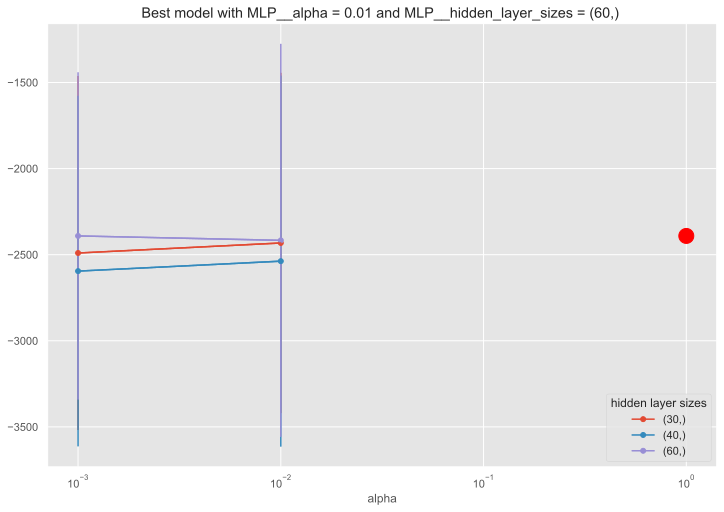

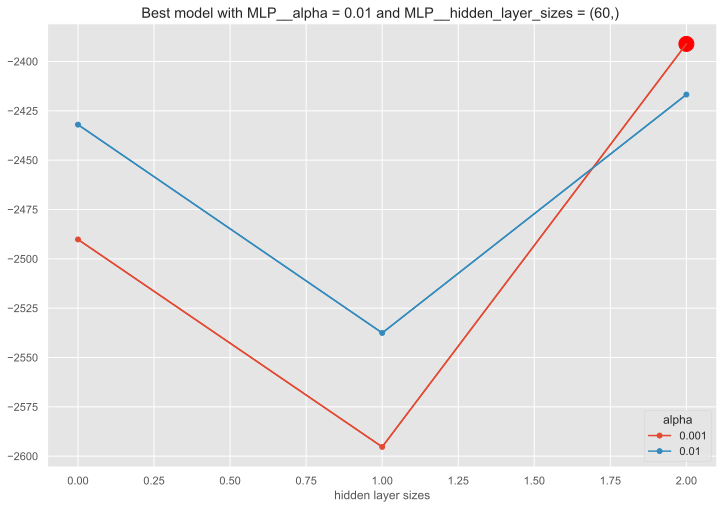

In [21]:
from utils import plotModelGridError
plotModelGridError(MLP_fit, xscale='log', figsize=(10, 6))

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred_A'] = MLP_fit_A.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred_A'] = MLP_fit.predict(X_test)


### 4. Modelo B (Solo parámetros relevantes)

In [11]:
INPUTS_MLP_NUM = ['strike', 'price', 'remaining', 'impliedVolatility']
INPUTS_MLP_CAT = None
INPUTS_MLP = INPUTS_MLP_NUM 

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
#categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM)
        #('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.01, 0.001], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(30,),(40,),(60,)],
         'MLP__learning_rate_init':[0.1]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit_B = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit_B.fit(X_train[INPUTS_MLP], y_train) # Search in grid


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17428D+04    |proj g|=  5.17631D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17757D+04    |proj g|=  5.10945D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08814D+04    |proj g|=  5.11233D+01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14606D+04    |proj g|=  5.09791D+01

At iterate    1    f=  1.10848D+04    |proj g|=  3.72549D+01

At iterate    1    f=  1.02334D+04    |proj g|=  3.66110D+01

At iterate    1    f=  1.11274D+04    |proj g|=  3.65925D+01

At iterate    1    f=  1.08142D+04    |proj g|=  3.64689D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12710D+04    |proj g|=  5.10183D+01

At iterate    2    f=  9.10663D+03    |proj g|=  5.48678D+01

At iterate    2    f=  9.91649D+03    |proj g|=  5.74286D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.17008D+03    |proj g|=  1.42043D+01

At iterate   11    f=  4.80265D+03    |proj g|=  2.18769D+01

At iterate    6    f=  7.82446D+03    |proj g|=  3.20854D+01

At iterate    6    f=  7.53679D+03    |proj g|=  4.07872D+01

At iterate   10    f=  4.67644D+03    |proj g|=  1.45031D+01

At iterate    8    f=  4.94193D+03    |proj g|=  1.74570D+01

At iterate    5    f=  8.27113D+03    |proj g|=  2.18527D+01

At iterate    7    f=  5.95907D+03    |proj g|=  2.43884D+01

At iterate   12    f=  4.33744D+03    |proj g|=  1.41020D+01

At iterate    7    f=  7.11123D+03    |proj g|=  1.99001D+01

At iterate    7    f=  7.36006D+03    |proj g|=  2.94436D+01

At iterate   11    f=  4.85321D+03    |proj g|=  1.37946D+01

At iterate    9    f=  4.57537D+03    |proj g|=  1.85937D+01

At iterate    8    f=  6.19681D+03    |proj g|=  1.76508D+01

At iterate   11    f=  4.43076D+03    |proj g|=  1.28393D+01

At iterate   13    f=  4.21496D+03    |proj g|=  9.33316D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs fa


At iterate  431    f=  1.11310D+03    |proj g|=  2.00516D+00

At iterate  447    f=  1.01779D+03    |proj g|=  1.16841D+01

At iterate  450    f=  1.09241D+03    |proj g|=  2.80343D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  181    450    539      1     0     0   2.803D+00   1.092D+03
  F =   1092.4068762879726     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  430    f=  1.09810D+03    |proj g|=  6.58408D-01

At iterate  432    f=  1.11293D+03    |proj g|=  3.25955D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate    5    f=  7.24458D+03    |proj g|=  3.05963D+01

At iterate  440    f=  1.09554D+03    |proj g|=  1.93116D+00

At iterate    9    f=  6.08811D+03    |proj g|=  1.19765D+01

At iterate  444    f=  1.10596D+03    |proj g|=  3.35571D+00

At iterate   14    f=  4.00437D+03    |proj g|=  1.23843D+01

At iterate    6    f=  6.53094D+03    |proj g|=  2.84932D+01

At iterate  441    f=  1.09524D+03    |proj g|=  9.40316D-01

At iterate  445    f=  1.10515D+03    |proj g|=  2.85373D+00

At iterate   15    f=  3.84363D+03    |proj g|=  1.05947D+01

At iterate    7    f=  5.46181D+03    |proj g|=  2.03177D+01

At iterate   10    f=  5.52223D+03    |proj g|=  1.89064D+01

At iterate  442    f=  1.09491D+03    |proj g|=  1.19884D+00

At iterate    2    f=  9.86267D+03    |proj g|=  4.30540D+01

At iterate    1    f=  1.10281D+04    |proj g|=  3.40298D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          241     M =           10

At X0         0 v

 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate   22    f=  3.21609D+03    |proj g|=  3.36686D+01

At iterate   33    f=  3.01932D+03    |proj g|=  1.20347D+01

At iterate   22    f=  3.10877D+03    |proj g|=  1.62356D+01

At iterate   38    f=  3.03260D+03    |proj g|=  7.72258D+00

At iterate   27    f=  2.87449D+03    |proj g|=  9.81684D+00

At iterate    9    f=  4.78611D+03    |proj g|=  1.13933D+01

At iterate   19    f=  3.18548D+03    |proj g|=  1.07543D+01

At iterate   34    f=  3.00149D+03    |proj g|=  8.35257D+00

At iterate   23    f=  3.16441D+03    |proj g|=  8.75112D+00

At iterate   39    f=  3.02377D+03    |proj g|=  1.11985D+01

At iterate   23    f=  3.03234D+03    |proj g|=  2.08796D+01

At iterate    1    f=  1.07490D+04    |proj g|=  3.36734D+01

At iterate   28    f=  2.84990D+03    |proj g|=  1.47409D+01

At iterate   10    f=  4.55630D+03    |proj g|=  1.74978D+01

At iterate   40    f=  3.01861D+03    |proj g|=  8.20564D+00

At iterate   35    f=  2.98136D+03    |proj g|=  5.28068D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  372    f=  1.28356D+03    |proj g|=  2.39698D+00

At iterate  366    f=  1.53155D+03    |proj g|=  1.29623D+00

At iterate  349    f=  1.20811D+03    |proj g|=  1.40305D+01

At iterate    1    f=  1.05258D+04    |proj g|=  3.39410D+01


At iterate  449    f=  1.14346D+03    |proj g|=  3.02093D+00
At iterate  357    f=  1.05487D+03    |proj g|=  1.61615D+00

At iterate  347    f=  1.14433D+03    |proj g|=  2.11891D+00

At iterate  373    f=  1.28313D+03    |proj g|=  1.13079D+00

At iterate  352    f=  1.29128D+03    |proj g|=  3.62907D+00

At iterate  350    f=  1.20726D+03    |proj g|=  8.98471D+00

At iterate  367    f=  1.53142D+03    |proj g|=  4.80867D+00

At iterate  358    f=  1.05448D+03    |proj g|=  1.56908D+00

At iterate  374    f=  1.28272D+03    |proj g|=  1.24694D+00

At iterate  351    f=  1.20623D+03    |proj g|=  7.27347D+00

At iterate  368    f=  1.53117D+03    |proj g|=  1.14257D+00

At iterate  353    f=  1.29069D+03    |proj g|=  9.40368D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  379    f=  1.28019D+03    |proj g|=  2.42512D+00

At iterate  364    f=  1.04872D+03    |proj g|=  7.43694D+00

At iterate  357    f=  1.20204D+03    |proj g|=  4.84477D+00

At iterate  359    f=  1.28656D+03    |proj g|=  2.33974D+00

At iterate  349    f=  1.12594D+03    |proj g|=  1.84892D+01

At iterate    1    f=  1.10981D+04    |proj g|=  3.46717D+01

At iterate  380    f=  1.27952D+03    |proj g|=  1.76536D+00

At iterate  375    f=  1.52839D+03    |proj g|=  2.69090D+00

At iterate    8    f=  5.05534D+03    |proj g|=  1.60468D+01

At iterate  360    f=  1.28610D+03    |proj g|=  4.22262D+00

At iterate  365    f=  1.04582D+03    |proj g|=  1.13316D+01

At iterate  381    f=  1.27891D+03    |proj g|=  2.10108D+00

At iterate    9    f=  4.68960D+03    |proj g|=  1.47611D+01

At iterate  358    f=  1.20141D+03    |proj g|=  6.58903D+00

At iterate  376    f=  1.52816D+03    |proj g|=  2.85557D+00

At iterate  382    f=  1.27777D+03    |proj g|=  2.42321D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   77    f=  2.57761D+03    |proj g|=  1.46803D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          241     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14635D+04    |proj g|=  5.07921D+01

At iterate  427    f=  1.17206D+03    |proj g|=  4.97675D+00

At iterate  424    f=  1.25430D+03    |proj g|=  4.04762D+00

At iterate   66    f=  2.72434D+03    |proj g|=  7.20853D+00

At iterate  431    f=  9.76787D+02    |proj g|=  3.03934D+00

At iterate   78    f=  2.57493D+03    |proj g|=  5.48147D+00

At iterate  419    f=  1.09261D+03    |proj g|=  1.09232D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          241     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16666D+04    |proj g|=  5.07989D+01

At iterate   67    f=  2.72048D+03    |proj g|=  5.14776D+00

At iterate  428    f=  1.17171D+03    |proj g

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:5


At iterate  445    f=  1.08054D+03    |proj g|=  5.61932D+00

At iterate   24    f=  3.14765D+03    |proj g|=  1.66251D+01

At iterate   22    f=  3.17087D+03    |proj g|=  3.84135D+01

At iterate    1    f=  1.00528D+04    |proj g|=  3.10430D+01

At iterate  447    f=  1.24195D+03    |proj g|=  3.85997D+00

At iterate  446    f=  1.07996D+03    |proj g|=  3.38593D+00

At iterate  448    f=  1.24074D+03    |proj g|=  1.91731D+00

At iterate   25    f=  3.11703D+03    |proj g|=  1.13175D+01

At iterate   23    f=  3.08398D+03    |proj g|=  1.11807D+01


At iterate   89    f=  2.57892D+03    |proj g|=  1.17846D+01
At iterate    2    f=  9.36559D+03    |proj g|=  4.02408D+01

At iterate  104    f=  2.48951D+03    |proj g|=  1.09794D+01

At iterate  447    f=  1.07931D+03    |proj g|=  2.10756D+00

At iterate  449    f=  1.23869D+03    |proj g|=  1.00272D+01

At iterate   24    f=  3.05060D+03    |proj g|=  1.16997D+01

At iterate   26    f=  3.09721D+03    |proj g|=  2.43613D+01

At iter

 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate   29    f=  2.93011D+03    |proj g|=  1.70093D+01

At iterate    2    f=  1.02509D+04    |proj g|=  4.06129D+01

At iterate  450    f=  1.07652D+03    |proj g|=  8.82896D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  241    450    524      1     0     0   8.829D+00   1.077D+03
  F =   1076.5191372203674     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f=  2.88789D+03    |proj g|=  2.31233D+01

At iterate    7    f=  6.79676D+03    |proj g|=  3.39343D+01

At iterate   96    f=  2.54081D+03    |proj g|=  1.03451D+01

At iterate   31    f=  2.85357D+03    |proj g|=  2.

 This problem is unconstrained.



At iterate  104    f=  2.50149D+03    |proj g|=  1.71498D+01

At iterate   40    f=  2.70211D+03    |proj g|=  1.05755D+01

At iterate   14    f=  3.68222D+03    |proj g|=  9.68429D+00

At iterate    9    f=  6.16677D+03    |proj g|=  1.21805D+01

At iterate  118    f=  2.44804D+03    |proj g|=  3.13671D+00

At iterate  105    f=  2.49039D+03    |proj g|=  1.69709D+01

At iterate    8    f=  6.75630D+03    |proj g|=  2.10349D+01

At iterate    4    f=  8.51751D+03    |proj g|=  4.89984D+00

At iterate   15    f=  3.52767D+03    |proj g|=  9.02282D+00

At iterate   41    f=  2.68335D+03    |proj g|=  7.81004D+00

At iterate  119    f=  2.44708D+03    |proj g|=  3.76033D+00

At iterate  106    f=  2.48465D+03    |proj g|=  7.86861D+00

At iterate    9    f=  6.07310D+03    |proj g|=  1.22117D+01

At iterate   10    f=  5.73450D+03    |proj g|=  1.17206D+01

At iterate   42    f=  2.67339D+03    |proj g|=  2.21194D+01

At iterate   43    f=  2.76004D+03    |proj g|=  1.54512D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  246    f=  1.19160D+03    |proj g|=  3.18210D+00

At iterate  414    f=  1.14475D+03    |proj g|=  1.97225D+00

At iterate  365    f=  1.27799D+03    |proj g|=  3.05280D+01

At iterate  248    f=  9.92644D+02    |proj g|=  7.90583D+00

At iterate  228    f=  1.31466D+03    |proj g|=  3.89715D+00

At iterate  242    f=  1.33822D+03    |proj g|=  4.54787D+00

At iterate  356    f=  1.09241D+03    |proj g|=  2.32687D+00

At iterate  415    f=  1.14449D+03    |proj g|=  1.99864D+00

At iterate  247    f=  1.18940D+03    |proj g|=  2.16272D+00

At iterate  357    f=  1.09197D+03    |proj g|=  1.76781D+00

At iterate  366    f=  1.27637D+03    |proj g|=  7.16414D+00

At iterate  229    f=  1.31238D+03    |proj g|=  8.91674D+00

At iterate  249    f=  9.91774D+02    |proj g|=  4.71731D+00

At iterate  416    f=  1.14418D+03    |proj g|=  1.62831D+00

At iterate  243    f=  1.33626D+03    |proj g|=  4.28064D+00

At iterate  248    f=  1.18644D+03    |proj g|=  2.04202D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  278    f=  1.27409D+03    |proj g|=  3.55849D+00


At iterate   33    f=  2.77048D+03    |proj g|=  3.39594D+00
At iterate  259    f=  1.23527D+03    |proj g|=  7.72725D+00

At iterate  409    f=  1.07079D+03    |proj g|=  1.35775D+00

At iterate  279    f=  1.12719D+03    |proj g|=  2.54776D+00

At iterate  284    f=  9.60641D+02    |proj g|=  4.34329D+00

At iterate  410    f=  1.07036D+03    |proj g|=  3.80567D+00

At iterate  279    f=  1.26958D+03    |proj g|=  3.63433D+00

At iterate  413    f=  1.23446D+03    |proj g|=  1.12956D+01

At iterate  260    f=  1.23405D+03    |proj g|=  3.21018D+00

At iterate   34    f=  2.74946D+03    |proj g|=  9.19968D+00

At iterate  280    f=  1.12482D+03    |proj g|=  3.29337D+00

At iterate  285    f=  9.60070D+02    |proj g|=  3.62040D+00

At iterate  280    f=  1.26374D+03    |proj g|=  3.39962D+00

At iterate  414    f=  1.23417D+03    |proj g|=  2.71809D+00

At iterate  261    f=  1.23252D+03    |proj g|=  7.04770D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  317    f=  9.36051D+02    |proj g|=  5.01602D+00

At iterate  311    f=  1.05546D+03    |proj g|=  4.45976D+00

At iterate    4    f=  8.30211D+03    |proj g|=  4.89148D+00

At iterate    1    f=  1.10156D+04    |proj g|=  3.16687D+01

At iterate   33    f=  2.84448D+03    |proj g|=  6.27619D+00

At iterate   66    f=  2.45924D+03    |proj g|=  6.36010D+00

At iterate  291    f=  1.19233D+03    |proj g|=  1.33480D+01

At iterate    5    f=  7.86636D+03    |proj g|=  1.26627D+01

At iterate  312    f=  1.05406D+03    |proj g|=  1.33347D+01

At iterate  318    f=  9.35570D+02    |proj g|=  5.66733D+00

At iterate   34    f=  2.83181D+03    |proj g|=  5.66850D+00

At iterate    2    f=  1.03013D+04    |proj g|=  4.14154D+01

At iterate   67    f=  2.44559D+03    |proj g|=  8.42485D+00

At iterate  292    f=  1.19145D+03    |proj g|=  4.58394D+00

At iterate  309    f=  1.16569D+03    |proj g|=  5.35508D+00

At iterate  319    f=  9.34799D+02    |proj g|=  8.68570D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  157    f=  1.88404D+03    |proj g|=  1.58374D+01

At iterate  141    f=  1.80156D+03    |proj g|=  1.24085D+01

At iterate  135    f=  2.15064D+03    |proj g|=  8.36114D+00

At iterate  445    f=  1.01569D+03    |proj g|=  1.87419D+00

At iterate  201    f=  1.55551D+03    |proj g|=  1.72937D+01

At iterate  422    f=  9.97869D+02    |proj g|=  1.84115D+01

At iterate  158    f=  1.87556D+03    |proj g|=  1.20006D+01


At iterate  446    f=  1.01548D+03    |proj g|=  1.21315D+01
At iterate  142    f=  1.79801D+03    |proj g|=  1.15026D+01

At iterate  202    f=  1.54725D+03    |proj g|=  5.97911D+00

At iterate  136    f=  2.14696D+03    |proj g|=  5.92524D+00

At iterate  435    f=  8.84178D+02    |proj g|=  2.78613D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          361     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14804D+04    |proj g|=  5.11944D+01

At iterate  143    f=  1.7

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  152    f=  2.06660D+03    |proj g|=  4.72386D+00

At iterate  155    f=  1.71257D+03    |proj g|=  1.45620D+01

At iterate  433    f=  9.78057D+02    |proj g|=  3.00632D+01

At iterate    9    f=  6.06012D+03    |proj g|=  1.31711D+01

At iterate  214    f=  1.51895D+03    |proj g|=  8.75917D+00

At iterate  173    f=  1.77632D+03    |proj g|=  7.12346D+00

At iterate  153    f=  2.05899D+03    |proj g|=  2.99674D+00

At iterate  156    f=  1.70573D+03    |proj g|=  6.62208D+00

At iterate   14    f=  4.05864D+03    |proj g|=  1.46288D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08814D+04    |proj g|=  5.11233D+01

At iterate   10    f=  5.60842D+03    |proj g|=  9.65798D+00

At iterate  154    f=  2.05311D+03    |proj g|=  5.82840D+00

At iterate   15    f=  3.90033D+03    |proj g|=  9.99441D+00

At iterate  157    f=  1.7

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate    1    f=  1.11274D+04    |proj g|=  3.65925D+01

At iterate   40    f=  2.77616D+03    |proj g|=  6.57022D+00

At iterate   39    f=  2.86582D+03    |proj g|=  6.24829D+00

At iterate   33    f=  2.77810D+03    |proj g|=  5.13634D+00

At iterate  238    f=  1.47734D+03    |proj g|=  1.02377D+01

At iterate   41    f=  2.77225D+03    |proj g|=  1.29902D+01

At iterate  177    f=  1.91104D+03    |proj g|=  5.85672D+00

At iterate  192    f=  1.60930D+03    |proj g|=  3.10176D+00

At iterate  181    f=  1.57942D+03    |proj g|=  4.24468D+00

At iterate   34    f=  2.76475D+03    |proj g|=  8.44862D+00

At iterate    2    f=  9.98551D+03    |proj g|=  5.72714D+01

At iterate   42    f=  2.75576D+03    |proj g|=  7.58872D+00

At iterate   40    f=  2.84774D+03    |proj g|=  7.05771D+00

At iterate  239    f=  1.47522D+03    |proj g|=  4.11887D+00

At iterate  193    f=  1.60483D+03    |proj g|=  7.79939D+00

At iterate   43    f=  2.74651D+03    |proj g|=  6.89527D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  388    f=  1.42128D+03    |proj g|=  5.79207D+00

At iterate  391    f=  1.06928D+03    |proj g|=  5.21723D+00

At iterate  384    f=  1.10406D+03    |proj g|=  1.63096D+00

At iterate  403    f=  1.33777D+03    |proj g|=  1.44118D+00

At iterate  419    f=  1.11900D+03    |proj g|=  3.68971D+00

At iterate  258    f=  1.41932D+03    |proj g|=  9.44396D+00

At iterate  385    f=  1.10384D+03    |proj g|=  1.11914D+00

At iterate  420    f=  1.11876D+03    |proj g|=  1.80303D+00


At iterate  389    f=  1.42082D+03    |proj g|=  2.21289D+00
At iterate    5    f=  7.94957D+03    |proj g|=  2.56018D+01


At iterate  392    f=  1.06864D+03    |proj g|=  5.71847D+00
At iterate  239    f=  1.13024D+03    |proj g|=  3.53474D+00

At iterate  386    f=  1.10359D+03    |proj g|=  1.98013D+00

At iterate  421    f=  1.11859D+03    |proj g|=  7.36868D-01

At iterate  259    f=  1.41876D+03    |proj g|=  6.19340D+00

At iterate  404    f=  1.33710D+03    |proj g|=  3.22284D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate   37    f=  3.02425D+03    |proj g|=  9.93713D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14606D+04    |proj g|=  5.09791D+01

At iterate  407    f=  1.41527D+03    |proj g|=  2.30311D+00

At iterate   38    f=  3.01037D+03    |proj g|=  8.13924D+00

At iterate  416    f=  1.09779D+03    |proj g|=  8.76449D-01

At iterate  257    f=  1.10097D+03    |proj g|=  5.10133D+00

At iterate  279    f=  1.40538D+03    |proj g|=  3.31545D+00

At iterate  423    f=  1.32699D+03    |proj g|=  3.59193D+00

At iterate  417    f=  1.09763D+03    |proj g|=  2.53310D+00

At iterate   39    f=  2.99711D+03    |proj g|=  6.56103D+00

At iterate  409    f=  1.04907D+03    |proj g|=  5.25857D+00

At iterate  408    f=  1.41494D+03    |proj g|=  2.22501D+00

At iterate    1    f=  1.08142D+04    |proj g|=  3.64689D+01

At iterate  258    f=  1.1

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  431    f=  1.02124D+03    |proj g|=  3.99188D+00

At iterate    7    f=  7.11122D+03    |proj g|=  1.99001D+01

At iterate   37    f=  2.97443D+03    |proj g|=  5.80093D+00

At iterate  445    f=  1.31579D+03    |proj g|=  4.86282D+00

At iterate   74    f=  2.78038D+03    |proj g|=  7.08935D+00

At iterate  431    f=  1.40621D+03    |proj g|=  2.39487D+00

At iterate    8    f=  6.19680D+03    |proj g|=  1.76508D+01

At iterate  281    f=  1.07491D+03    |proj g|=  2.39180D+00

At iterate   38    f=  2.96313D+03    |proj g|=  1.72419D+01

At iterate  302    f=  1.38834D+03    |proj g|=  3.77009D+00

At iterate  432    f=  1.01991D+03    |proj g|=  4.15444D+00

At iterate    9    f=  5.46778D+03    |proj g|=  1.92861D+01

At iterate   75    f=  2.77781D+03    |proj g|=  7.89582D+00

At iterate  446    f=  1.31535D+03    |proj g|=  2.67973D+00

At iterate   39    f=  2.94996D+03    |proj g|=  9.20098D+00

At iterate  282    f=  1.07422D+03    |proj g|=  3.17230D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  439    f=  1.01510D+03    |proj g|=  2.79648D+00

At iterate   87    f=  2.70128D+03    |proj g|=  1.61679D+01

At iterate   20    f=  3.26788D+03    |proj g|=  2.34085D+01

At iterate  310    f=  1.38274D+03    |proj g|=  3.98822D+00

At iterate   49    f=  2.82156D+03    |proj g|=  1.02407D+01

At iterate   21    f=  3.26494D+03    |proj g|=  1.62408D+01

At iterate   88    f=  2.69446D+03    |proj g|=  9.17163D+00

At iterate    2    f=  9.72929D+03    |proj g|=  5.68305D+01

At iterate   50    f=  2.81171D+03    |proj g|=  1.32698D+01

At iterate  290    f=  1.06862D+03    |proj g|=  3.03998D+00

At iterate   22    f=  3.19612D+03    |proj g|=  1.77431D+01

At iterate  311    f=  1.38199D+03    |proj g|=  3.42426D+00

At iterate    3    f=  8.86398D+03    |proj g|=  2.94336D+01

At iterate  439    f=  1.40419D+03    |proj g|=  3.05896D+00

At iterate  440    f=  1.01443D+03    |proj g|=  3.33475D+00

At iterate   89    f=  2.68948D+03    |proj g|=  9.25002D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    2    f=  1.00239D+04    |proj g|=  5.88223D+01

At iterate   44    f=  2.78984D+03    |proj g|=  1.42678D+01

At iterate  111    f=  2.64028D+03    |proj g|=  7.13579D+00

At iterate  323    f=  1.37350D+03    |proj g|=  3.90038D+00

At iterate  307    f=  1.05562D+03    |proj g|=  3.20255D+00

At iterate   31    f=  3.14165D+03    |proj g|=  1.76757D+01

At iterate   73    f=  2.67428D+03    |proj g|=  1.25012D+01

At iterate    3    f=  9.10249D+03    |proj g|=  3.10721D+01

At iterate   45    f=  2.77397D+03    |proj g|=  1.10142D+01

At iterate  112    f=  2.63822D+03    |proj g|=  3.50942D+00

At iterate    5    f=  7.55443D+03    |proj g|=  2.85205D+01

At iterate   32    f=  3.11382D+03    |proj g|=  5.40054D+00

At iterate   46    f=  2.76928D+03    |proj g|=  7.89417D+00

At iterate   74    f=  2.66609D+03    |proj g|=  5.13653D+00

At iterate  324    f=  1.37278D+03    |proj g|=  1.05686D+01

At iterate    4    f=  8.51271D+03    |proj g|=  1.95844D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  220    f=  1.37386D+03    |proj g|=  7.37201D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14825D+04    |proj g|=  5.12489D+01

At iterate  205    f=  1.40333D+03    |proj g|=  5.57082D+00

At iterate  276    f=  1.21741D+03    |proj g|=  1.45222D+01

At iterate  253    f=  1.20764D+03    |proj g|=  1.43550D+01

At iterate  206    f=  1.40005D+03    |proj g|=  1.66667D+01


At iterate  277    f=  1.21531D+03    |proj g|=  3.78564D+00
At iterate  324    f=  1.21359D+03    |proj g|=  4.68407D+00

At iterate  277    f=  1.20215D+03    |proj g|=  4.60269D+00

At iterate  254    f=  1.20535D+03    |proj g|=  2.42231D+00

At iterate  221    f=  1.37114D+03    |proj g|=  1.28362D+01

At iterate  437    f=  9.78857D+02    |proj g|=  1.61499D+00

At iterate  207    f=  1.39261D+03    |proj g|=  7.95139D+00

At iterate  278    f=  1.2

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  238    f=  1.28768D+03    |proj g|=  3.08813D+00

At iterate  284    f=  1.11488D+03    |proj g|=  1.05709D+01

At iterate  309    f=  1.17988D+03    |proj g|=  4.47344D+00

At iterate    2    f=  9.88748D+03    |proj g|=  5.74703D+01

At iterate  315    f=  1.18204D+03    |proj g|=  3.35812D+00

At iterate   29    f=  3.15250D+03    |proj g|=  5.95923D+00

At iterate  310    f=  1.17934D+03    |proj g|=  1.53581D+00

At iterate  253    f=  1.24542D+03    |proj g|=  2.29008D+01

At iterate  354    f=  1.18862D+03    |proj g|=  5.86945D+00

At iterate  316    f=  1.18166D+03    |proj g|=  6.13032D+00

At iterate  239    f=  1.28396D+03    |proj g|=  4.21965D+00

At iterate  285    f=  1.11308D+03    |proj g|=  8.52438D+00

At iterate   30    f=  3.12862D+03    |proj g|=  8.25252D+00


At iterate  254    f=  1.24187D+03    |proj g|=  1.37482D+01
At iterate  311    f=  1.17878D+03    |proj g|=  3.13013D+00


At iterate  317    f=  1.18030D+03    |proj g|=  4.31837D+00
At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate    1    f=  1.01347D+04    |proj g|=  3.40440D+01

At iterate  335    f=  1.20459D+03    |proj g|=  1.09851D+00

At iterate  429    f=  1.14073D+03    |proj g|=  9.93272D+00

At iterate  368    f=  1.13297D+03    |proj g|=  1.39614D+00

At iterate  134    f=  2.06642D+03    |proj g|=  4.16414D+01

At iterate  410    f=  1.11518D+03    |proj g|=  2.16729D+00

At iterate  336    f=  1.20392D+03    |proj g|=  1.51529D+00

At iterate  430    f=  1.14026D+03    |proj g|=  2.05128D+00

At iterate  135    f=  2.02172D+03    |proj g|=  3.50562D+01

At iterate  369    f=  1.13264D+03    |proj g|=  1.42542D+00

At iterate  411    f=  1.11495D+03    |proj g|=  1.74198D+00

At iterate  337    f=  1.20251D+03    |proj g|=  2.23534D+00

At iterate  136    f=  1.98784D+03    |proj g|=  3.48297D+01

At iterate  101    f=  2.62972D+03    |proj g|=  7.10667D+00

At iterate  392    f=  1.06363D+03    |proj g|=  6.56036D+00

At iterate  412    f=  1.11487D+03    |proj g|=  4.09670D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  126    f=  2.25723D+03    |proj g|=  4.15473D+00

At iterate  360    f=  1.17964D+03    |proj g|=  3.38301D+00

At iterate  158    f=  1.61320D+03    |proj g|=  1.92752D+01

At iterate  437    f=  1.11065D+03    |proj g|=  3.24752D+00

At iterate  392    f=  1.10962D+03    |proj g|=  6.40311D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          241     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17570D+04    |proj g|=  5.06377D+01

At iterate  127    f=  2.22678D+03    |proj g|=  3.36860D+01

At iterate  361    f=  1.17901D+03    |proj g|=  2.78091D+00

At iterate  413    f=  1.04289D+03    |proj g|=  2.07951D+00

At iterate  393    f=  1.10819D+03    |proj g|=  3.18011D+00

At iterate  438    f=  1.11033D+03    |proj g|=  5.33201D+00


At iterate  159    f=  1.60633D+03    |proj g|=  3.37927D+01

At iterate  362    f=  1.17862D+03    |proj g|=  2.29116D+00
At iterate   25    f=  2.9

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  150    f=  1.67761D+03    |proj g|=  3.16875D+01

At iterate  184    f=  1.44317D+03    |proj g|=  1.19420D+01

At iterate  440    f=  1.03922D+03    |proj g|=  7.39413D-01

At iterate  415    f=  1.10028D+03    |proj g|=  9.91246D-01

At iterate   20    f=  3.28031D+03    |proj g|=  1.38391D+01

At iterate  389    f=  1.16695D+03    |proj g|=  1.13074D+01

At iterate    7    f=  6.07490D+03    |proj g|=  1.99138D+01

At iterate   48    f=  2.65890D+03    |proj g|=  1.45902D+01

At iterate  185    f=  1.44020D+03    |proj g|=  1.03961D+01

At iterate  441    f=  1.03904D+03    |proj g|=  4.96732D-01

At iterate  416    f=  1.10020D+03    |proj g|=  1.55552D+00

At iterate   21    f=  3.21231D+03    |proj g|=  1.81029D+01

At iterate  151    f=  1.66489D+03    |proj g|=  2.40060D+01

At iterate    8    f=  5.35791D+03    |proj g|=  1.51590D+01

At iterate  417    f=  1.10004D+03    |proj g|=  1.78703D+00

At iterate  186    f=  1.43817D+03    |proj g|=  6.05942D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate   18    f=  3.39474D+03    |proj g|=  1.12173D+01

At iterate  426    f=  1.09572D+03    |proj g|=  8.62548D+00

At iterate   58    f=  2.59006D+03    |proj g|=  1.08097D+01

At iterate   31    f=  2.89326D+03    |proj g|=  4.84750D+00

At iterate   19    f=  3.36036D+03    |proj g|=  2.04078D+01

At iterate  427    f=  1.09524D+03    |proj g|=  1.61820D+01

At iterate  195    f=  1.41836D+03    |proj g|=  5.14055D+00

At iterate  397    f=  1.11441D+03    |proj g|=  4.29588D+00

At iterate  163    f=  1.55946D+03    |proj g|=  1.64305D+01

At iterate   59    f=  2.58322D+03    |proj g|=  6.79518D+00

At iterate  428    f=  1.09421D+03    |proj g|=  7.15931D+00

At iterate   32    f=  2.87903D+03    |proj g|=  6.72315D+00

At iterate    1    f=  1.07159D+04    |proj g|=  3.39036D+01

At iterate  398    f=  1.11294D+03    |proj g|=  4.16156D+00

At iterate  164    f=  1.55117D+03    |proj g|=  6.87770D+00

At iterate  196    f=  1.41566D+03    |proj g|=  9.95911D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate   75    f=  2.49568D+03    |proj g|=  1.81799D+01

At iterate   52    f=  2.66228D+03    |proj g|=  5.13465D+00

At iterate  422    f=  1.10033D+03    |proj g|=  1.18192D+00

At iterate  186    f=  1.41538D+03    |proj g|=  9.49513D+00

At iterate   20    f=  3.11999D+03    |proj g|=  1.16988D+01

At iterate  221    f=  1.36080D+03    |proj g|=  5.78678D+00

At iterate   39    f=  2.92484D+03    |proj g|=  4.52580D+01

At iterate   53    f=  2.65345D+03    |proj g|=  1.00588D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          241     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13324D+04    |proj g|=  5.05536D+01

At iterate  423    f=  1.10005D+03    |proj g|=  3.77856D+00

At iterate  187    f=  1.41356D+03    |proj g|=  1.02686D+01

At iterate   40    f=  2.89796D+03    |proj g|=  1.06160D+01

At iterate  222    f=  1.36058D+03    |proj g|=  7.54118D+00

At iterate   21    f=  3.0

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  261    f=  1.31663D+03    |proj g|=  7.52534D+00

At iterate   53    f=  2.62792D+03    |proj g|=  8.36855D+00

At iterate   29    f=  2.80216D+03    |proj g|=  1.26345D+01

At iterate    4    f=  8.26958D+03    |proj g|=  1.49449D+01

At iterate  224    f=  1.27969D+03    |proj g|=  3.50166D+00

At iterate   82    f=  2.51208D+03    |proj g|=  5.91114D+00

At iterate  104    f=  2.40733D+03    |proj g|=  2.05894D+00

At iterate  262    f=  1.31578D+03    |proj g|=  3.84636D+00

At iterate  225    f=  1.27803D+03    |proj g|=  1.21721D+01

At iterate   69    f=  2.68132D+03    |proj g|=  1.22692D+01

At iterate   30    f=  2.78939D+03    |proj g|=  6.12957D+00

At iterate   54    f=  2.62383D+03    |proj g|=  1.74146D+01

At iterate   83    f=  2.50775D+03    |proj g|=  1.03930D+01

At iterate  263    f=  1.31520D+03    |proj g|=  2.78055D+00

At iterate  105    f=  2.40583D+03    |proj g|=  3.32744D+00

At iterate  226    f=  1.27580D+03    |proj g|=  9.05057D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  187    f=  1.36650D+03    |proj g|=  1.80290D+01

At iterate  235    f=  1.39388D+03    |proj g|=  1.48109D+01

At iterate  419    f=  1.12449D+03    |proj g|=  9.29855D+00

At iterate  161    f=  2.13709D+03    |proj g|=  2.62804D+01

At iterate  261    f=  1.14692D+03    |proj g|=  1.10928D+01

At iterate  209    f=  1.71074D+03    |proj g|=  1.66417D+01


At iterate  245    f=  1.34238D+03    |proj g|=  7.76746D+00
At iterate  420    f=  1.12432D+03    |proj g|=  4.01243D+00

At iterate  236    f=  1.39244D+03    |proj g|=  7.94718D+00

At iterate    5    f=  7.69425D+03    |proj g|=  3.39232D+01

At iterate  188    f=  1.34838D+03    |proj g|=  1.74104D+01

At iterate  162    f=  2.13151D+03    |proj g|=  2.29950D+01

At iterate  262    f=  1.14368D+03    |proj g|=  1.88477D+01

At iterate  421    f=  1.12418D+03    |proj g|=  1.58211D+00

At iterate  237    f=  1.39028D+03    |proj g|=  9.42892D+00

At iterate  210    f=  1.68568D+03    |proj g|=  1.39487D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          241     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18374D+04    |proj g|=  5.12857D+01

At iterate  259    f=  1.33104D+03    |proj g|=  1.57969D+01

At iterate  268    f=  1.30979D+03    |proj g|=  2.21815D+00

At iterate  189    f=  1.56805D+03    |proj g|=  2.34529D+01

At iterate  285    f=  1.08364D+03    |proj g|=  9.82773D+00

At iterate  214    f=  1.17365D+03    |proj g|=  1.27004D+01

At iterate  269    f=  1.30826D+03    |proj g|=  5.78998D+00

At iterate  235    f=  1.44176D+03    |proj g|=  2.63156D+01

At iterate  260    f=  1.32842D+03    |proj g|=  3.66941D+00

At iterate  190    f=  1.55426D+03    |proj g|=  2.00093D+01

At iterate   32    f=  2.80340D+03    |proj g|=  1.13120D+01

At iterate  215    f=  1.17258D+03    |proj g|=  7.79758D+00

At iterate  270    f=  1.30718D+03    |proj g|=  4.85261D+00

At iterate    1    f=  1.1

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  448    f=  1.09044D+03    |proj g|=  1.21630D+00

At iterate  215    f=  1.81766D+03    |proj g|=  8.27626D+00

At iterate  435    f=  1.19132D+03    |proj g|=  4.75155D+00

At iterate  396    f=  9.94339D+02    |proj g|=  7.71128D+00

At iterate  216    f=  1.81208D+03    |proj g|=  1.90786D+01

At iterate  413    f=  1.13413D+03    |proj g|=  4.19555D+00

At iterate  372    f=  1.20192D+03    |proj g|=  9.70657D+00

At iterate  449    f=  1.09026D+03    |proj g|=  2.18277D+00

At iterate  174    f=  1.99742D+03    |proj g|=  1.34629D+01

At iterate    5    f=  7.86767D+03    |proj g|=  3.02855D+01

At iterate  397    f=  9.94148D+02    |proj g|=  1.48112D+00

At iterate  414    f=  1.13371D+03    |proj g|=  5.12260D+00

At iterate  217    f=  1.81023D+03    |proj g|=  3.37887D+01

At iterate  450    f=  1.09011D+03    |proj g|=  2.73556D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  183    f=  1.84924D+03    |proj g|=  2.10526D+01

At iterate  421    f=  1.12957D+03    |proj g|=  1.98194D+00

At iterate   15    f=  3.81490D+03    |proj g|=  1.17623D+01

At iterate  225    f=  1.74339D+03    |proj g|=  4.34689D+01

At iterate  441    f=  1.17259D+03    |proj g|=  3.59016D+00

At iterate  406    f=  9.90506D+02    |proj g|=  1.50713D+00

At iterate  184    f=  1.82211D+03    |proj g|=  1.18057D+01

At iterate  422    f=  1.12937D+03    |proj g|=  1.27999D+01

At iterate   16    f=  3.73134D+03    |proj g|=  1.48414D+01

At iterate  442    f=  1.17152D+03    |proj g|=  8.37984D+00

At iterate  226    f=  1.73535D+03    |proj g|=  2.16962D+01

At iterate  381    f=  1.19793D+03    |proj g|=  3.02382D+00

At iterate  407    f=  9.89920D+02    |proj g|=  4.98936D+00

At iterate    2    f=  9.83613D+03    |proj g|=  4.31182D+01

At iterate  185    f=  1.80958D+03    |proj g|=  2.88717D+01

At iterate  423    f=  1.12890D+03    |proj g|=  3.48051D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  240    f=  1.63853D+03    |proj g|=  8.45441D+01

At iterate   19    f=  3.38767D+03    |proj g|=  1.99333D+01

At iterate  397    f=  1.19142D+03    |proj g|=  1.70154D+00

At iterate   32    f=  2.95853D+03    |proj g|=  2.51390D+01

At iterate  422    f=  9.83630D+02    |proj g|=  4.40129D+00

At iterate  437    f=  1.12394D+03    |proj g|=  1.00322D+00

At iterate  241    f=  1.63202D+03    |proj g|=  6.87223D+01

At iterate  398    f=  1.19120D+03    |proj g|=  1.23890D+00

At iterate  242    f=  1.61935D+03    |proj g|=  2.36019D+01

At iterate  200    f=  1.52077D+03    |proj g|=  2.31898D+01

At iterate  438    f=  1.12377D+03    |proj g|=  2.19899D+00

At iterate  423    f=  9.83317D+02    |proj g|=  5.63127D+00

At iterate   20    f=  3.32027D+03    |proj g|=  2.50160D+01

At iterate  243    f=  1.60826D+03    |proj g|=  2.49537D+01

At iterate    1    f=  1.00528D+04    |proj g|=  3.10430D+01

At iterate   33    f=  2.93753D+03    |proj g|=  1.77558D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  260    f=  1.46599D+03    |proj g|=  1.75536D+01

At iterate   15    f=  3.52775D+03    |proj g|=  9.02242D+00

At iterate  217    f=  1.42583D+03    |proj g|=  8.40404D+00

At iterate  413    f=  1.15262D+03    |proj g|=  3.07548D+00

At iterate   53    f=  2.72504D+03    |proj g|=  4.81308D+00

At iterate   39    f=  2.76443D+03    |proj g|=  8.75081D+00

At iterate  445    f=  9.75468D+02    |proj g|=  1.88840D+00

At iterate  261    f=  1.45888D+03    |proj g|=  3.62327D+01

At iterate    2    f=  1.02509D+04    |proj g|=  4.06129D+01

At iterate   54    f=  2.71480D+03    |proj g|=  1.10760D+01

At iterate   40    f=  2.75582D+03    |proj g|=  6.91749D+00

At iterate  218    f=  1.42367D+03    |proj g|=  3.48069D+00

At iterate  446    f=  9.75299D+02    |proj g|=  5.18001D+00

At iterate  414    f=  1.15210D+03    |proj g|=  1.95101D+00

At iterate   16    f=  3.40235D+03    |proj g|=  4.82415D+00

At iterate  262    f=  1.45287D+03    |proj g|=  3.44295D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  423    f=  1.14883D+03    |proj g|=  6.20964D+00

At iterate   64    f=  2.64955D+03    |proj g|=  9.76677D+00

At iterate   50    f=  2.64107D+03    |proj g|=  5.77105D+00

At iterate   23    f=  2.90722D+03    |proj g|=  1.14498D+01

At iterate    1    f=  1.09016D+04    |proj g|=  3.16873D+01

At iterate  424    f=  1.14861D+03    |proj g|=  3.67462D+00

At iterate   65    f=  2.64634D+03    |proj g|=  8.25817D+00

At iterate  228    f=  1.39555D+03    |proj g|=  8.02930D+00

At iterate  272    f=  1.41268D+03    |proj g|=  3.32523D+01

At iterate   10    f=  5.73449D+03    |proj g|=  1.17204D+01

At iterate   51    f=  2.63567D+03    |proj g|=  7.12169D+00

At iterate  425    f=  1.14831D+03    |proj g|=  1.61387D+00

At iterate   24    f=  2.88291D+03    |proj g|=  5.96141D+00

At iterate  229    f=  1.39317D+03    |proj g|=  8.85762D+00

At iterate   66    f=  2.63940D+03    |proj g|=  9.80697D+00

At iterate  273    f=  1.40821D+03    |proj g|=  1.41046D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  259    f=  1.30977D+03    |proj g|=  1.05951D+01

At iterate  301    f=  1.33012D+03    |proj g|=  2.29703D+01

At iterate   80    f=  2.51005D+03    |proj g|=  4.70628D+00

At iterate   31    f=  2.86652D+03    |proj g|=  1.34380D+01

At iterate   24    f=  3.19557D+03    |proj g|=  6.71178D+00

At iterate   46    f=  2.52138D+03    |proj g|=  1.04185D+01

At iterate   95    f=  2.55779D+03    |proj g|=  4.65843D+00

At iterate  302    f=  1.32839D+03    |proj g|=  2.74909D+01

At iterate   81    f=  2.50767D+03    |proj g|=  6.43704D+00

At iterate   25    f=  3.13474D+03    |proj g|=  5.04122D+00

At iterate   96    f=  2.55625D+03    |proj g|=  7.14009D+00

At iterate  303    f=  1.32582D+03    |proj g|=  8.69922D+00

At iterate  260    f=  1.30618D+03    |proj g|=  1.54748D+01

At iterate   32    f=  2.84770D+03    |proj g|=  7.38925D+00

At iterate   47    f=  2.49813D+03    |proj g|=  7.01005D+00

At iterate   97    f=  2.55437D+03    |proj g|=  7.52544D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  396    f=  1.15772D+03    |proj g|=  3.09319D+00

At iterate  231    f=  1.24977D+03    |proj g|=  5.80388D+00

At iterate  234    f=  1.43180D+03    |proj g|=  6.14230D+00

At iterate  134    f=  1.83457D+03    |proj g|=  1.09082D+01

At iterate  102    f=  2.32648D+03    |proj g|=  7.74319D+00

At iterate  397    f=  1.15727D+03    |proj g|=  1.33953D+00

At iterate  130    f=  1.88886D+03    |proj g|=  1.32473D+01

At iterate  232    f=  1.24769D+03    |proj g|=  4.54380D+00

At iterate  103    f=  2.32212D+03    |proj g|=  2.50958D+00

At iterate  398    f=  1.15686D+03    |proj g|=  9.03959D-01

At iterate  235    f=  1.42448D+03    |proj g|=  7.13999D+00

At iterate  233    f=  1.24526D+03    |proj g|=  1.12837D+01

At iterate  135    f=  1.81892D+03    |proj g|=  7.85443D+00

At iterate  149    f=  1.39513D+03    |proj g|=  1.00460D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          361     M =           10

At X0         0 v

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate   34    f=  2.71705D+03    |proj g|=  1.22375D+01

At iterate  286    f=  1.17151D+03    |proj g|=  5.11167D+00

At iterate  187    f=  1.16198D+03    |proj g|=  6.21687D+00

At iterate  167    f=  1.67913D+03    |proj g|=  4.09071D+00

At iterate  174    f=  1.45463D+03    |proj g|=  2.17525D+01

At iterate  290    f=  1.33254D+03    |proj g|=  5.61054D+00

At iterate  287    f=  1.17061D+03    |proj g|=  3.47333D+00

At iterate  188    f=  1.15868D+03    |proj g|=  7.75503D+00

At iterate   35    f=  2.69420D+03    |proj g|=  4.67722D+00

At iterate  288    f=  1.16929D+03    |proj g|=  5.65412D+00

At iterate  175    f=  1.44295D+03    |proj g|=  1.75086D+01

At iterate  168    f=  1.67547D+03    |proj g|=  1.57180D+01

At iterate  139    f=  2.07624D+03    |proj g|=  2.12514D+01

At iterate  291    f=  1.33136D+03    |proj g|=  3.68852D+00

At iterate   36    f=  2.67730D+03    |proj g|=  6.05414D+00

At iterate  189    f=  1.15580D+03    |proj g|=  6.16199D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  450    f=  1.08643D+03    |proj g|=  1.60447D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  241    450    513      1     0     0   1.604D+00   1.086D+03
  F =   1086.4329858194899     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  113    f=  2.26864D+03    |proj g|=  4.57578D+00

At iterate  293    f=  1.08871D+03    |proj g|=  3.36321D+00

At iterate    2    f=  9.75535D+03    |proj g|=  4.00928D+01

At iterate  284    f=  1.50357D+03    |proj g|=  4.60034D+00

At iterate  310    f=  1.00581D+03    |proj g|=  9.92703D+00

At iterate  114    f=  2.26319D+03    |proj g|=  5

 This problem is unconstrained.



At iterate  254    f=  1.26563D+03    |proj g|=  3.76265D+00

At iterate  157    f=  1.72950D+03    |proj g|=  4.56729D+00

At iterate  118    f=  2.24028D+03    |proj g|=  4.11053D+00

At iterate  290    f=  1.49636D+03    |proj g|=  7.70023D+00

At iterate  300    f=  1.07870D+03    |proj g|=  4.11837D+00

At iterate  315    f=  9.99731D+02    |proj g|=  2.07863D+00

At iterate  255    f=  1.26440D+03    |proj g|=  2.65514D+00

At iterate  158    f=  1.72828D+03    |proj g|=  2.01201D+01

At iterate  316    f=  9.99153D+02    |proj g|=  3.52851D+00

At iterate  301    f=  1.07689D+03    |proj g|=  2.49977D+00

At iterate    1    f=  1.10156D+04    |proj g|=  3.16687D+01

At iterate    9    f=  5.68277D+03    |proj g|=  1.04656D+01

At iterate  119    f=  2.23357D+03    |proj g|=  5.76467D+00

At iterate  291    f=  1.49568D+03    |proj g|=  2.02427D+00

At iterate  256    f=  1.26322D+03    |proj g|=  4.83623D+00

At iterate  302    f=  1.07542D+03    |proj g|=  4.14370D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  387    f=  1.12843D+03    |proj g|=  1.71785D+01

At iterate  150    f=  1.86988D+03    |proj g|=  3.14566D+00

At iterate  444    f=  9.65814D+02    |proj g|=  1.17765D+00

At iterate  141    f=  2.08509D+03    |proj g|=  9.05381D+00

At iterate  388    f=  1.12717D+03    |proj g|=  7.79705D+00

At iterate  422    f=  1.42924D+03    |proj g|=  2.24451D+00

At iterate  151    f=  1.86648D+03    |proj g|=  3.39914D+00

At iterate  142    f=  2.07625D+03    |proj g|=  7.74048D+00

At iterate  445    f=  9.65184D+02    |proj g|=  1.25231D+00

At iterate  152    f=  1.86263D+03    |proj g|=  7.68038D+00

At iterate    1    f=  1.06516D+04    |proj g|=  3.11694D+01

At iterate  297    f=  1.42753D+03    |proj g|=  2.27814D+01

At iterate  389    f=  1.12625D+03    |proj g|=  2.18005D+00

At iterate  249    f=  1.60596D+03    |proj g|=  1.02766D+01

At iterate  143    f=  2.06682D+03    |proj g|=  5.39515D+00

At iterate    2    f=  9.95818D+03    |proj g|=  4.04369D+01

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  302    f=  1.42135D+03    |proj g|=  6.42999D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          361     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16835D+04    |proj g|=  5.12012D+01

At iterate    8    f=  6.59163D+03    |proj g|=  2.12795D+01

At iterate  147    f=  2.01982D+03    |proj g|=  1.46949D+01

At iterate  255    f=  1.59682D+03    |proj g|=  3.36249D+00

At iterate  393    f=  1.11974D+03    |proj g|=  3.55666D+01

At iterate  148    f=  2.00941D+03    |proj g|=  8.85997D+00

At iterate  158    f=  1.84094D+03    |proj g|=  5.73116D+00

At iterate  256    f=  1.59387D+03    |proj g|=  5.06237D+00

At iterate    9    f=  5.87124D+03    |proj g|=  9.21707D+00

At iterate  159    f=  1.83628D+03    |proj g|=  6.63756D+00

At iterate  303    f=  1.42065D+03    |proj g|=  2.82367D+00

At iterate  430    f=  1.42683D+03    |proj g|=  3.59406D+00

At iterate   10    f=  5.5

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  328    f=  1.40141D+03    |proj g|=  2.73475D+00

At iterate  181    f=  1.76650D+03    |proj g|=  2.86674D+00

At iterate   34    f=  2.89739D+03    |proj g|=  7.58813D+00

At iterate  279    f=  1.53822D+03    |proj g|=  9.87273D+00

At iterate  414    f=  1.09315D+03    |proj g|=  5.45577D+00

At iterate  170    f=  1.81143D+03    |proj g|=  4.60777D+00

At iterate  182    f=  1.76398D+03    |proj g|=  5.06108D+00

At iterate  329    f=  1.40103D+03    |proj g|=  1.82727D+00

At iterate  280    f=  1.53704D+03    |proj g|=  5.14701D+00

At iterate   35    f=  2.88476D+03    |proj g|=  4.48056D+00

At iterate  415    f=  1.09210D+03    |proj g|=  8.10009D+00

At iterate  171    f=  1.80766D+03    |proj g|=  4.46930D+00

At iterate  183    f=  1.75849D+03    |proj g|=  6.74571D+00

At iterate  330    f=  1.40029D+03    |proj g|=  4.86327D+00

At iterate  281    f=  1.53460D+03    |proj g|=  5.03980D+00

At iterate   36    f=  2.87358D+03    |proj g|=  6.85254D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   78    f=  2.40152D+03    |proj g|=  3.45317D+01

At iterate  232    f=  1.65653D+03    |proj g|=  3.48008D+00

At iterate  333    f=  1.45764D+03    |proj g|=  3.01097D+00

At iterate   64    f=  2.56166D+03    |proj g|=  1.77641D+01


At iterate  379    f=  1.36925D+03    |proj g|=  1.28451D+01
At iterate  219    f=  1.54558D+03    |proj g|=  9.00041D+00

At iterate   79    f=  2.39250D+03    |proj g|=  7.32202D+00

At iterate  233    f=  1.65460D+03    |proj g|=  1.19589D+01

At iterate  334    f=  1.45686D+03    |proj g|=  3.09784D+00

At iterate   65    f=  2.55446D+03    |proj g|=  6.88399D+00

At iterate  220    f=  1.54302D+03    |proj g|=  4.31917D+00

At iterate   80    f=  2.38474D+03    |proj g|=  8.34461D+00

At iterate  335    f=  1.45626D+03    |proj g|=  3.47748D+00

At iterate   66    f=  2.54722D+03    |proj g|=  3.67126D+00

At iterate  234    f=  1.65254D+03    |proj g|=  6.32641D+00

At iterate  221    f=  1.54157D+03    |proj g|=  8.10820D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  419    f=  1.41661D+03    |proj g|=  1.64264D+00

At iterate  308    f=  1.45268D+03    |proj g|=  1.13792D+01

At iterate  320    f=  1.46490D+03    |proj g|=  6.77886D+00

At iterate  166    f=  1.71992D+03    |proj g|=  5.20243D+00

At iterate  420    f=  1.41594D+03    |proj g|=  2.22033D+00

At iterate  309    f=  1.45166D+03    |proj g|=  2.03133D+00

At iterate  149    f=  1.45353D+03    |proj g|=  7.44834D+00

At iterate  321    f=  1.46400D+03    |proj g|=  5.46306D+00

At iterate  167    f=  1.71548D+03    |proj g|=  5.34825D+00

At iterate  421    f=  1.41543D+03    |proj g|=  4.31752D+00

At iterate  310    f=  1.45141D+03    |proj g|=  1.70687D+00

At iterate  150    f=  1.43832D+03    |proj g|=  8.45472D+00

At iterate  322    f=  1.46254D+03    |proj g|=  5.52162D+00

At iterate  168    f=  1.71111D+03    |proj g|=  3.51123D+00

At iterate  422    f=  1.41483D+03    |proj g|=  2.53607D+00

At iterate  311    f=  1.45086D+03    |proj g|=  5.83388D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  342    f=  1.43983D+03    |proj g|=  9.37577D+00

At iterate  178    f=  1.25365D+03    |proj g|=  5.45406D+00

At iterate  198    f=  1.58062D+03    |proj g|=  3.83963D+00

At iterate  354    f=  1.42206D+03    |proj g|=  3.44682D+00

At iterate  343    f=  1.43950D+03    |proj g|=  1.51977D+00

At iterate  199    f=  1.57976D+03    |proj g|=  4.51189D+00

At iterate  355    f=  1.42115D+03    |proj g|=  3.41665D+00

At iterate  200    f=  1.57817D+03    |proj g|=  1.93911D+00

At iterate  344    f=  1.43930D+03    |proj g|=  1.61015D+00

At iterate  179    f=  1.25108D+03    |proj g|=  4.90486D+00

At iterate  356    f=  1.42022D+03    |proj g|=  4.39884D+00

At iterate  345    f=  1.43898D+03    |proj g|=  3.87412D+00

At iterate  180    f=  1.24879D+03    |proj g|=  5.50570D+00

At iterate  357    f=  1.41938D+03    |proj g|=  3.72449D+00

At iterate  201    f=  1.57683D+03    |proj g|=  3.29304D+00

At iterate  346    f=  1.43853D+03    |proj g|=  4.38111D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  295    f=  1.49062D+03    |proj g|=  1.81121D+00

At iterate  276    f=  1.09352D+03    |proj g|=  2.00906D+00

At iterate  439    f=  1.40411D+03    |proj g|=  2.45322D+00

At iterate  296    f=  1.48996D+03    |proj g|=  9.37121D+00

At iterate  277    f=  1.09309D+03    |proj g|=  3.37938D+00

At iterate  440    f=  1.40356D+03    |proj g|=  2.55734D+00

At iterate  278    f=  1.09202D+03    |proj g|=  2.87428D+00

At iterate  297    f=  1.48921D+03    |proj g|=  2.43901D+00

At iterate  298    f=  1.48865D+03    |proj g|=  2.19951D+00

At iterate  279    f=  1.08874D+03    |proj g|=  2.42128D+00

At iterate  441    f=  1.40339D+03    |proj g|=  4.94329D+00

At iterate  299    f=  1.48833D+03    |proj g|=  4.57158D+00

At iterate  280    f=  1.08680D+03    |proj g|=  6.81427D+00

At iterate  442    f=  1.40322D+03    |proj g|=  2.46534D+00

At iterate  281    f=  1.08424D+03    |proj g|=  7.34677D+00

At iterate  443    f=  1.40285D+03    |proj g|=  1.99315D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  303    f=  1.05415D+03    |proj g|=  6.55169D+00

At iterate  321    f=  1.47272D+03    |proj g|=  2.24673D+00

At iterate  304    f=  1.05354D+03    |proj g|=  1.76431D+00

At iterate  322    f=  1.47214D+03    |proj g|=  3.97526D+00

At iterate  305    f=  1.05336D+03    |proj g|=  1.58951D+00

At iterate  323    f=  1.47165D+03    |proj g|=  7.31166D+00

At iterate  306    f=  1.05240D+03    |proj g|=  2.79325D+00

At iterate  324    f=  1.47107D+03    |proj g|=  2.10469D+00

At iterate  307    f=  1.05147D+03    |proj g|=  2.93542D+00

At iterate  325    f=  1.47050D+03    |proj g|=  2.15966D+00

At iterate  308    f=  1.04981D+03    |proj g|=  8.02591D+00

At iterate  326    f=  1.46933D+03    |proj g|=  2.10642D+00

At iterate  309    f=  1.04879D+03    |proj g|=  4.05640D+00

At iterate  310    f=  1.04759D+03    |proj g|=  2.43609D+00

At iterate  327    f=  1.46651D+03    |proj g|=  4.04599D+00

At iterate  311    f=  1.04596D+03    |proj g|=  3.97645D+00

At iter

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  445    f=  9.92364D+02    |proj g|=  2.94777D+00

At iterate  446    f=  9.91902D+02    |proj g|=  1.85939D+00

At iterate  447    f=  9.91379D+02    |proj g|=  2.30388D+00

At iterate  448    f=  9.91246D+02    |proj g|=  2.26743D+00

At iterate  449    f=  9.91177D+02    |proj g|=  1.09870D+00

At iterate  450    f=  9.91059D+02    |proj g|=  1.04646D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  361    450    496      1     0     0   1.046D+00   9.911D+02
  F =   991.05893949541257     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['strike',
                                                                          'price',
                                                                          'remaining',
                                                                          'impliedVolatility'])])),
                                       ('MLP',
                                        MLPRegressor(activation='logistic',
                                                     max_iter=450,
                                                     random_state=150,
                                                     solver='lbfgs',
                                                     verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [0.01, 0.001],
                         'MLP__hidden_layer_sizes': [(30,), (40,), (60,)],
                         'MLP__learning_rate_init': [0.1]},
             scoring='neg_mean_squared_error')

In [15]:
# Save both models
import joblib
joblib.dump(MLP_fit_A, '../models/MLP_fit_small_A.pkl')
joblib.dump(MLP_fit_B, '../models/MLP_fit_small_B.pkl')

['../models/MLP_fit_small_B.pkl']

In [14]:
dfTR_eval

strike  volume  openInterest  impliedVolatility inTheMoney   price  \
92475     70.0    40.0       13452.0           0.268562      False   66.62   
76709    124.0    26.0         626.0           0.593754      False   84.00   
11215    237.5     4.0           4.0           0.293342      False  215.62   
17919    185.0     6.0          16.0           0.246590      False  173.01   
535      110.0     1.0         931.0           0.503911       True  132.02   
...        ...     ...           ...                ...        ...     ...   
52452    980.0   100.0         108.0           0.339972      False  880.62   
133827   135.0     2.0          35.0           0.423529      False   88.26   
45597     75.0     1.0          95.0           0.525578       True   86.98   
114940    65.0     1.0          63.0           0.000010       True  132.85   
105705   135.0     1.0         435.0           0.479711       True  163.85   

        duration  remaining  midPrice  
92475         22         22     0.450  
76709         43         22     0.025  
11215         23         22     0.675  
17919         50         50     2.125  
535           29         22    22.575  
...          ...        ...       ...  
52452         27         22     2.150  
133827       295        295     1.880  
45597        582        568    27.350  
114940       364        232    57.950  
105705       295        295    41.500  

[16000 rows x 9 columns]

### 5. Comparación de modelos

In [12]:
# Load both models from models/MLP_fit_small_A.pkl and MLP_fit_small_B.pkl
import joblib
MLP_fit_A = joblib.load('../models/MLP_fit_small_A.pkl')
MLP_fit_B = joblib.load('../models/MLP_fit_small_B.pkl')

In [13]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred_A'] = MLP_fit_A.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred_A'] = MLP_fit_A.predict(X_test)

## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred_B'] = MLP_fit_B.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred_B'] = MLP_fit_B.predict(X_test)

In [15]:
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred_A']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred_A']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred_A'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred_A'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['MLP_pred_A']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['MLP_pred_A']))

Training MAE: 13.39900549452825
Test MAE: 17.0415355886975
Training RMSE: 37.783215789410015
Test RMSE: 74.45168634425275
Training R2: 0.9299429881705332
Test R2: 0.7341436972794282


In [16]:
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred_B']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred_B']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred_B'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred_B'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['MLP_pred_B']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['MLP_pred_B']))

Training MAE: 15.10859329532229
Test MAE: 19.065329253832452
Training RMSE: 47.00909536560217
Test RMSE: 81.23727640092777
Training R2: 0.891552995755178
Test R2: 0.6834745813820056


In [27]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['Y'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [28]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()

Sensitivity analysis of [9, 60, 1] MLP network.

Sensitivity measures of each output:

$Y 

                              mean         std  mean_squared
num__strike            -151.915321  220.602696    267.850358
num__volume              -8.864976   44.119501     45.001313
num__openInterest        -2.269361   18.078349     18.220228
num__impliedVolatility   -2.248604  168.524673    168.539673
num__price              188.083987  256.133089    317.773103
num__duration            -3.861561  189.050965    189.090400
num__remaining           15.046191  184.784807    185.396367
cat__inTheMoney_0.0    -262.532600  377.178086    459.550514
cat__inTheMoney_1.0      90.488389  299.409813    312.784886


In [30]:
sensmlp.info()

Sensitivity analysis of [9, 60, 1] MLP network.

16000 samples

Sensitivities of each output (only 5 first samples):

$Y 

    num__strike   num__volume  num__openInterest  num__impliedVolatility  \
0  1.962100e-13  2.072234e-15      -7.381172e-16           -3.360795e-14   
1  1.258860e-24 -1.270130e-25      -1.313352e-26           -1.493071e-25   
2  1.651574e-12 -1.666601e-13      -1.723266e-14           -1.958817e-13   
3  1.560589e-16 -2.131388e-17      -1.925757e-18           -4.600127e-17   
4 -3.509501e+02 -2.375127e+00       1.296067e+00           -5.211507e+00   

     num__price  num__duration  num__remaining  cat__inTheMoney_0.0  \
0  2.720617e-13   1.766969e-14   -7.398617e-14         1.083490e-13   
1  1.979087e-24   5.887657e-25   -4.757238e-25        -4.687417e-25   
2  2.596510e-12   7.723213e-13   -6.243854e-13        -6.153453e-13   
3  2.583699e-16   8.056091e-17   -6.568789e-17        -5.013867e-17   
4  3.561956e+02  -3.684863e+01    3.597646e+01        -5.677273e+

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/neuralsens/partial_derivatives.py:1749: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


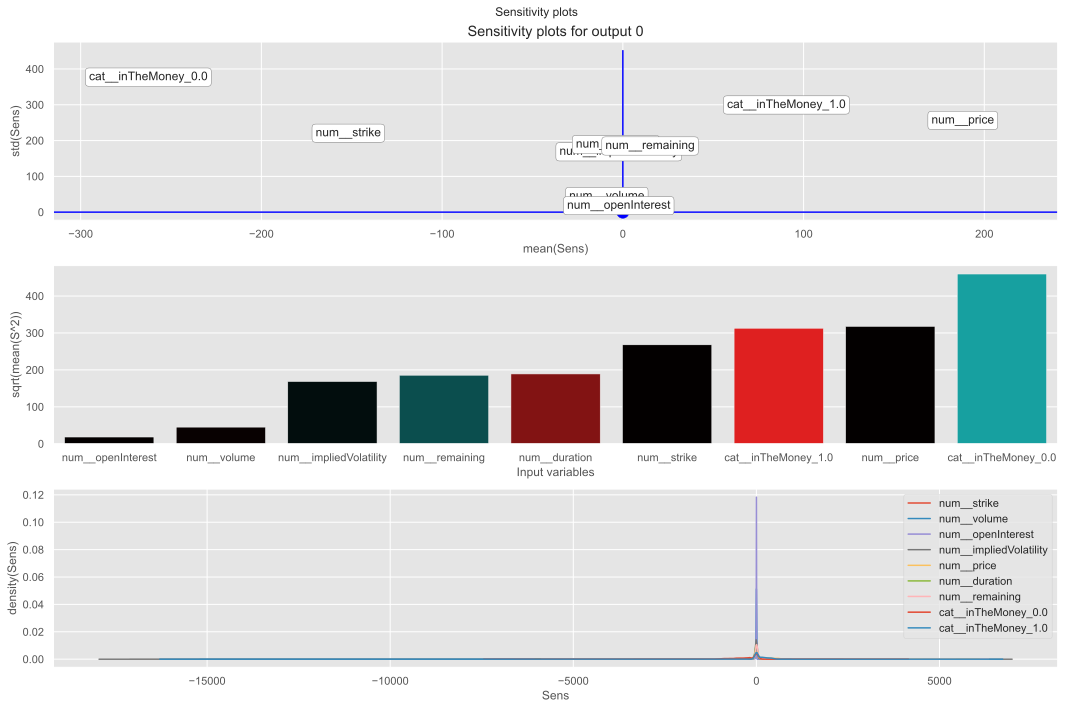

In [31]:
sensmlp.plot()

array([<Axes: xlabel='$\\alpha$', ylabel='$(ms_{X,j}^\\alpha(f))$'>,
       <Axes: >], dtype=object)

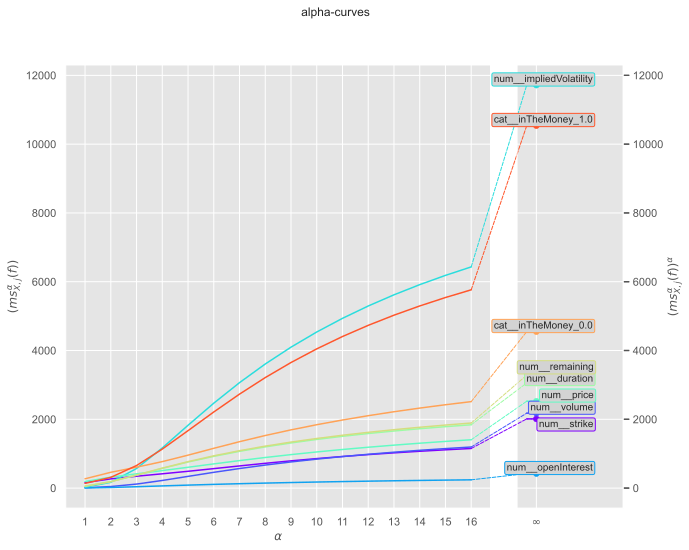

In [32]:
ns.alpha_sens_curves(sensmlp)

In [33]:
hessmlp = ns.hessian_mlp(wts, bias, actfunc, X, y)
hessmlp.summary()

: 

In [21]:
def plotModelGridError(MLP_fit):
    # Extraer los resultados de la búsqueda en cuadrícula
    results = MLP_fit.cv_results_
    mean_test_scores = results['mean_test_score']  # promedio de los puntajes de validación
    params = results['params']  # combinaciones de hiperparámetros
    
    # Convertir las puntuaciones a errores (1 - score)
    errors = 1 - mean_test_scores
    
    # Crear etiquetas para cada combinación de hiperparámetros
    param_labels = [f"lr: {param['MLP__learning_rate_init']}, size: {param['MLP__hidden_layer_sizes']}" for param in params]
    
    # Ordenar los errores y etiquetas en orden decreciente
    sorted_indices = np.argsort(errors)[::-1]  # Ordenar de mayor a menor
    errors_sorted = errors[sorted_indices]
    param_labels_sorted = [param_labels[i] for i in sorted_indices]
    
    # Crear el gráfico de error de cuadrícula
    plt.figure(figsize=(12, 6))
    plt.barh(param_labels_sorted, errors_sorted, color='skyblue')
    plt.xlabel("Error de Modelo (1 - Accuracy)")
    plt.title("Model Grid Error (Ordenado por Error Decreciente)")
    plt.gca().invert_yaxis()  # invertir el eje y para mostrar el mejor resultado en la parte superior
    plt.show()

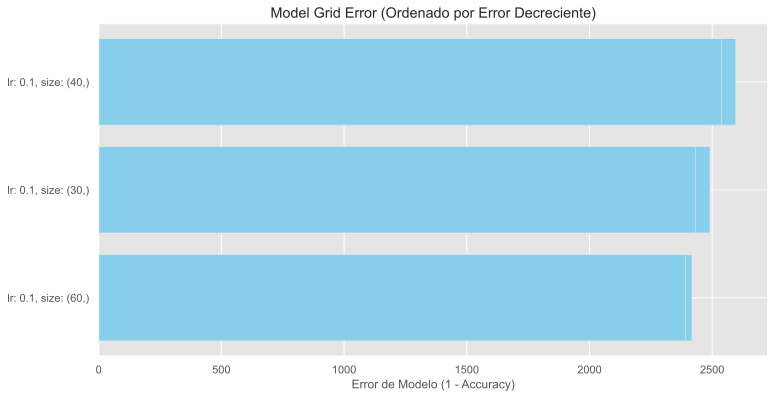

In [22]:
plotModelGridError(MLP_fit_A)